##### The University of Melbourne, School of Computing and Information Systems

**COMP30027 Machine Learning, 2022 Semester 1**

---

# **Assignment 2:** Sentiment Classification of Tweets

---

In [159]:
## Import all necessary modules for (Needed Installations Flagged):
# general use
import pandas as pd # INSTALL NEEDED
from collections import Counter, defaultdict
import numpy as np # INSTALL NEEDED
from scipy.sparse import csr_matrix, hstack, vstack # INSTALL NEEDED
from pprint import pprint # INSTALL NEEDED
import sklearn as skl # INSTALL NEEDED
import warnings
# plotting
import matplotlib.pyplot as plt # INSTALL NEEDED
from wordcloud import WordCloud # INSTALL NEEDED
# feature extraction
import re
from sklearn.feature_extraction import DictVectorizer # INSTALL NEEDED
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # INSTALL NEEDED
import nltk # INSTALL NEEDED
nltk.download('stopwords')
from nltk.corpus import stopwords # INSTALL NEEDED
NLTK_STOPWORDS = list(stopwords.words())
from nltk.stem import PorterStemmer # INSTALL NEEDED
import pronouncing # INSTALL NEEDED
# classification
# classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # INSTALL NEEDED
from sklearn.linear_model import LogisticRegression # INSTALL NEEDED
from sklearn.tree import DecisionTreeClassifier # INSTALL NEEDED
from sklearn.neighbors import KNeighborsClassifier # INSTALL NEEDED
from sklearn.svm import SVC, LinearSVC # INSTALL NEEDED
from sklearn.dummy import DummyClassifier # INSTALL NEEDED
from sklearn.ensemble import BaggingClassifier # INSTALL NEEDED
# evaluation
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# set the plot font sizes
# ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Travers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Raw Data Analysis

A shallow analysis of the dataset.

### Importing the data

In [2]:
train_df = pd.read_csv("../data/Train.csv", sep=',')
test_df = pd.read_csv("../data/Test.csv", sep=',')

### Basic Information
Specifically the types of the data and the lengths of each set.

In [3]:
# get information about types in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [4]:
# get information about types in the testing set
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6099 non-null   int64 
 1   text    6099 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


### Inspecting Instances 
To verify what they look like when `pandas` imports them.

In [5]:
# inspect the head of the training information
train_df.head()

Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  
0   doctors hit campaign trail as race to medical...   neutral  
1   is anybody going to the radio station tomorro...  positive  
2   i just found out naruto didn't become the 5th...   neutral  
3   "prince george reservist who died saturday ju...   neutral  
4   season in the sun versi nirvana rancak gak..s...  positive

In [6]:
# inspect the head of the testing information
test_df.head()

id                                               text
0  802217876644052000   @loogunda @poroshenko putin abducted ukrainia...
1  802425296955682000   if putin wanted to intervene all he would hav...
2  805664502515662000   @hillbuzz @gaypatriot elsewhere in progland.....
3  639928670103015000   any females copping the gucci foamposites tom...
4  673824182287904000   "in other news, had a great saturday on the t...

In [7]:
# show a random sample from the training information
train_df.sample(5)

Unnamed: 0                  id  \
10188       13028  633498327502295000   
7491         9565  637301198182318000   
7626         9736  800851253064368000   
10174       13009  630530962854686000   
10741       13723  638130014890946000   

                                                    text sentiment  
10188   these kids born in the 90s didnt know a ice c...   neutral  
7491    "@andygoldstein05 i'll go kane in......one of...   neutral  
7626    rt @merriamwebster: in the news: 'alt-right' ...  negative  
10174   r.i.p. frank gifford. i truly enjoyed your mo...  positive  
10741   i may watch the vmas just to see nicki's perf...  positive

In [8]:
# show a random sample from the testing information
test_df.sample(5)

id                                               text
3993  802201404194619000   #trumptrain #maga #draintheswamp #neverromney...
2413  638202689743032000  remember this when you watch the news stories ...
3139  640176826468466000   @ebuka_akara @ekajnr super eagles goalkeeper ...
2580  630093205497905000   "@sarabareilles so, you didn't show up at zac...
1205  681827597962096000   @purposetourcom selling 4 justin bieber stand...

### Distribution of Sentiments

There may be a majority sentiment in the `Train.csv`.

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


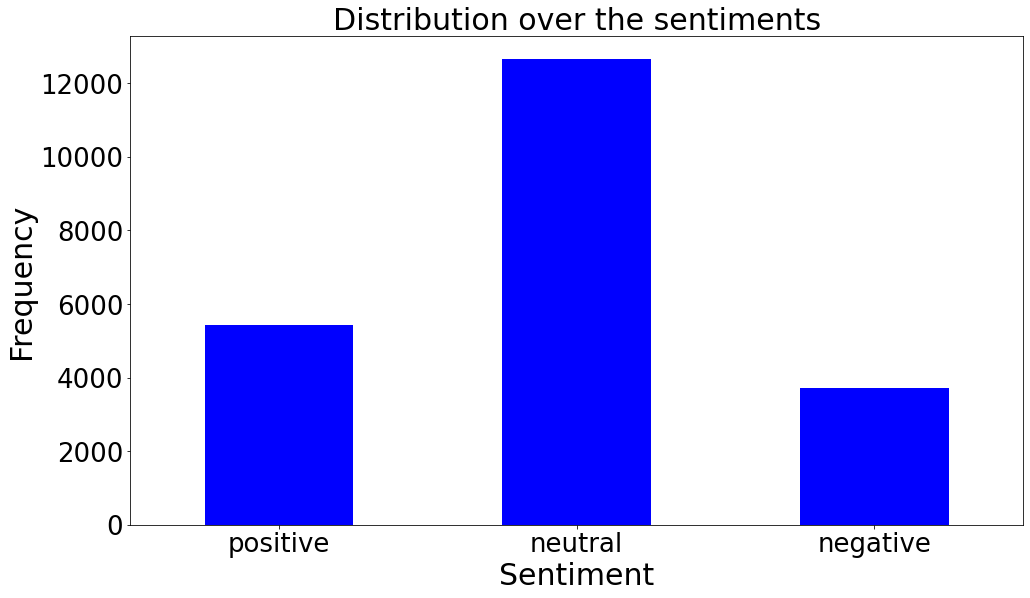

In [9]:
# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))

# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

## 2. Data Preprocessing

Functionality for cleaning the text data

### Cleaning Functionality
A simple cleaning function for the data with modifiable features.

In [10]:
## pre-cache the regex
# common tweet feature regex
RE_LINKS = re.compile(r'https?://t.co/\w*')
RE_HASHTAGS = re.compile(r'(?<=\W)#\w*[a-z]\w*')
RE_MENTIONS = re.compile(r'(?<=\W)@\w+')
# other re
RE_REPEATED_CONSECUTIVES = re.compile(r'(.)\1+')
RE_NUMBERS = re.compile(r'\d+')
RE_NON_ALPHANUMERIC = re.compile(r'[^a-z]+')
RE_PUNCTUATION = re.compile(r'[\.?!,:;\-()\[\]{}"\'/]')

# list of different terms to clean
DEFAULT_CLEAN_DICT = {
    'links': True,
    'hashtags': True,
    'mentions': True,
    'numbers': True,
    'non-alphanumeric': True,
    'repeated-consecutive': True,
    'stopwords': None, # removing stopwords
}

# a function to selectively clean different terms within tweets
def clean_tweet(tweet: str, remove: dict = DEFAULT_CLEAN_DICT) -> str:
    new_tweet = tweet
    re_stopwords = ''
    if remove['stopwords'] is not None: 
        re_stopwords = re.compile(r'\b(' + r'|'.join(remove['stopwords']) + r')\b\s*')
    if remove['links']: new_tweet = RE_LINKS.sub(' ', new_tweet)
    if remove['hashtags']: new_tweet = RE_HASHTAGS.sub(' ', new_tweet)
    if remove['mentions']: new_tweet = RE_MENTIONS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['repeated-consecutive']: new_tweet = RE_REPEATED_CONSECUTIVES.sub(r'\1\1', new_tweet)
    if remove['numbers']: new_tweet = RE_NUMBERS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['non-alphanumeric']: 
        new_tweet = RE_NON_ALPHANUMERIC.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)

    # remove unnecessary space characters
    new_tweet = re.sub(r' +', ' ', new_tweet)
    new_tweet = re.sub(r'^ | $', '', new_tweet) # bookend spaces
    return new_tweet

# apply the default cleaning function to the training and test sets
train_df['text-clean-no-stopwords'] = train_df['text'].apply(clean_tweet)
test_df['text-clean-no-stopwords'] = test_df['text'].apply(clean_tweet)

# inspect a sample of the training information and compare the clean and raw tweets
train_df.sample(5)

Unnamed: 0                  id  \
611           796  641382922348576000   
20289       25902  678393964660133000   
536           700  622823455357018000   
18451       23483  634102792240562000   
10973       14032  641138268692594000   

                                                    text sentiment  \
611     john cena and i will be unable to attend the ...   neutral   
20289  but iran itself is discriminating against #afg...  negative   
536     paul dunne kept the poise going in the rinald...  positive   
18451  i'm laying in the sun listening to frank ocean...  positive   
10973   frank ocean it is july 69th my nigga where yo...   neutral   

                                 text-clean-no-stopwords  
611    john cena and i will be unable to attend the c...  
20289  but iran itself is discriminating against refu...  
536    paul dunne kept the poise going in the rinaldi...  
18451  i m laying in the sun listening to frank ocean...  
10973  frank ocean it is july th my nigga where yo al...

### Identifying Stopwords
Words with little value to be removed

In [11]:
# start the wordcloud object here
wc = WordCloud(max_words=750, width=1920, height=1080)

# a function to display and save a named word cloud
def show_save_word_cloud(text, filename):
    cloud = wc.generate(text)
    plt.figure(figsize= (16, 9), frameon=False)
    plt.axis('off')
    print(f'Word cloud for {filename}')
    plt.imshow(cloud)
    plt.savefig(f'../report/img/wc/{filename}', bbox_inches='tight')

# show and save the wc for train, test, all
if False: # this code hangs sometimes, so change this to run it again
    # show_save_word_cloud(" ".join(train_df['text-clean-default']), 'train-clean-default')
    # show_save_word_cloud(" ".join(test_df['text-clean-default']), 'test-clean-default')
    show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']) + " " + " ".join(test_df['text-clean-no-stopwords']), 
        'text-clean-no-stopwords')

    # generate the wc for `positive`, `neutral` and `negative` instances only
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']),
        f'{sentiment}-clean-no-stopwords')

In [12]:
# NLTK's stopword list is most applicable (+ add stuff from re-analysis)
FINAL_STOPWORDS = ['amp', 'may', 'th', 'st'] + NLTK_STOPWORDS

# apply the cleaning with the different stopword lists
cleanConfig = DEFAULT_CLEAN_DICT.copy()
cleanConfig['stopwords'] = NLTK_STOPWORDS
train_df['text-clean-nltk'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean-nltk'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
cleanConfig['stopwords'] = FINAL_STOPWORDS
train_df['text-clean'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))

FINAL_CLEAN_CONFIG = cleanConfig

# generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
if False: # this code hangs sometimes, so change this to run it again
    show_save_word_cloud(" ".join(train_df['text-clean-nltk']) + " " + " ".join(test_df['text-clean-nltk']), 
        'all-clean-nltk')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-nltk']),
        f'{sentiment}-clean-nltk')

    # generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
    show_save_word_cloud(" ".join(train_df['text-clean']) + " " + " ".join(test_df['text-clean']), 
        'all-clean-final')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean']),
        f'{sentiment}-clean-final')

# compare the differences
train_df.sample(5)

Unnamed: 0                  id  \
12711       16291  627781969603072000   
7228         9216  675742753372831000   
6141         7816  635636316118646000   
11974       15324  801943232351469000   
18443       23474  637843639885012000   

                                                    text sentiment  \
12711   buhari has shifted his campaign promise on bo...  negative   
7228    "our holiday open house is in full swing!!! p...  positive   
6141    "@lawradio @wwerollins no, because he'll lose...  negative   
11974   i know there are objectively way more morally...  negative   
18443  @pandora_na recognizes most top religions-chri...  negative   

                                 text-clean-no-stopwords  \
12711  buhari has shifted his campaign promise on bok...   
7228   our holiday open house is in full swing please...   
6141   no because he ll lose the u s title to john ce...   
11974  i know there are objectively way more morally ...   
18443  pandora na recognizes most top religions chris...   

                                         text-clean-nltk  \
12711  buhari shifted campaign promise boko haram cla...   
7228   holiday open house full swing please stop noon...   
6141                 lose title john cena tomorrow night   
11974  know objectively way morally depraved evil thi...   
18443  pandora recognizes top religions christianity ...   

                                              text-clean  
12711  buhari shifted campaign promise boko haram cla...  
7228   holiday open house full swing please stop noon...  
6141                 lose title john cena tomorrow night  
11974  know objectively way morally depraved evil thi...  
18443  pandora recognizes top religions christianity ...

## 3. Vectorizers
Three transformers are going to be used `TfidfVectorizer`, `CountVectorizer` and `DictVectorizer`.
The following is code to compare the different features produced on a bar graph (showing those most influential).

In [13]:
# define the colours for the different sentiment sets
SENTIMENT_COLOURS = {
    'all': 'orange',
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

# create a bar graph (and save it)
def show_save_bar_graph(plot, X:csr_matrix, y: list[str], features: list[str], 
        feature_type: str, sentiment: str, sort_type: str='relative', 
        max_features: int|None=10, labels=False, save=False):

    # ensure the max features are not higher than the length
    if max_features > len(features) or max_features == None: 
        max_features = len(features)
    # fill the value list for the bars
    values = np.zeros((len(features)))
    sums = np.zeros((len(features)))
    for idx, f in enumerate(features):
        all_entries = X[:, idx]
        s_entries = all_entries[y == sentiment]
        sums[idx] = np.sum(all_entries)
        if sentiment == 'all': 
            values[idx] = np.sum(all_entries) / len(y)
        elif sort_type == 'relative':
            values[idx] = np.sum(s_entries) / np.sum(all_entries)
        else:
            values[idx] = np.sum(s_entries) / len(y[y == sentiment])
    values_sums_names = sorted(zip(values, sums, features), reverse=True)[:max_features]
    values = [vn[0] for vn in values_sums_names]
    features = [vn[2] for vn in values_sums_names]
    plot.bar(range(max_features), values, color=SENTIMENT_COLOURS[sentiment])
    if labels:
        plot.xlabel(f'Top {max_features} Features',) 
        plot.ylabel(f'{sort_type} Value',) 
    plot.set_xticks(range(max_features))
    plot.set_xticklabels(features, rotation=45, ha='right')
    plot.set_title(f'{sentiment.upper()} {feature_type} Bar Graph')
    if save:
        plt.savefig(f'../report/img/bar/{sentiment}', bbox_inches='tight')


# create a method to generate 4 bar graphs for top features in a vector based on their relative sums
def compare_bars(X, y, features, feature_type: str, sort_type: str='relative', max_features: int|None=10):

    if max_features > len(features): max_features = len(features)
    f, axes = plt.subplots(1, 4)
    f.set_size_inches([32, 12])

    # set the labels
    f.supxlabel(f'Top {max_features} Features', va='baseline')
    f.supylabel(f'{sort_type.upper()} Value')
    f.suptitle(f'Comparing {feature_type} across sentiments')
    f.subplots_adjust(bottom=0.25, wspace=0.3)

    show_save_bar_graph(axes[0], X, y, features, '-', 'all', sort_type, max_features)

    for idx, sentiment in enumerate(['positive', 'neutral', 'negative']):
        show_save_bar_graph(axes[idx+1], X, y, features, '-', sentiment, sort_type, max_features)

    plt.savefig(f'../report/img/bar/compare-{feature_type}', bbox_inches='tight')


## 4. Tokenization

Implementing different forms of token/vector generation.

In [14]:
# define the X dictionaries and y for the sentiments
X_train_features = dict()
X_test_features = dict()
y = train_df['sentiment']

# for the sake of comparison/testing, set the # of max features to smth low
MAX_FEATURES = 5000

### Words

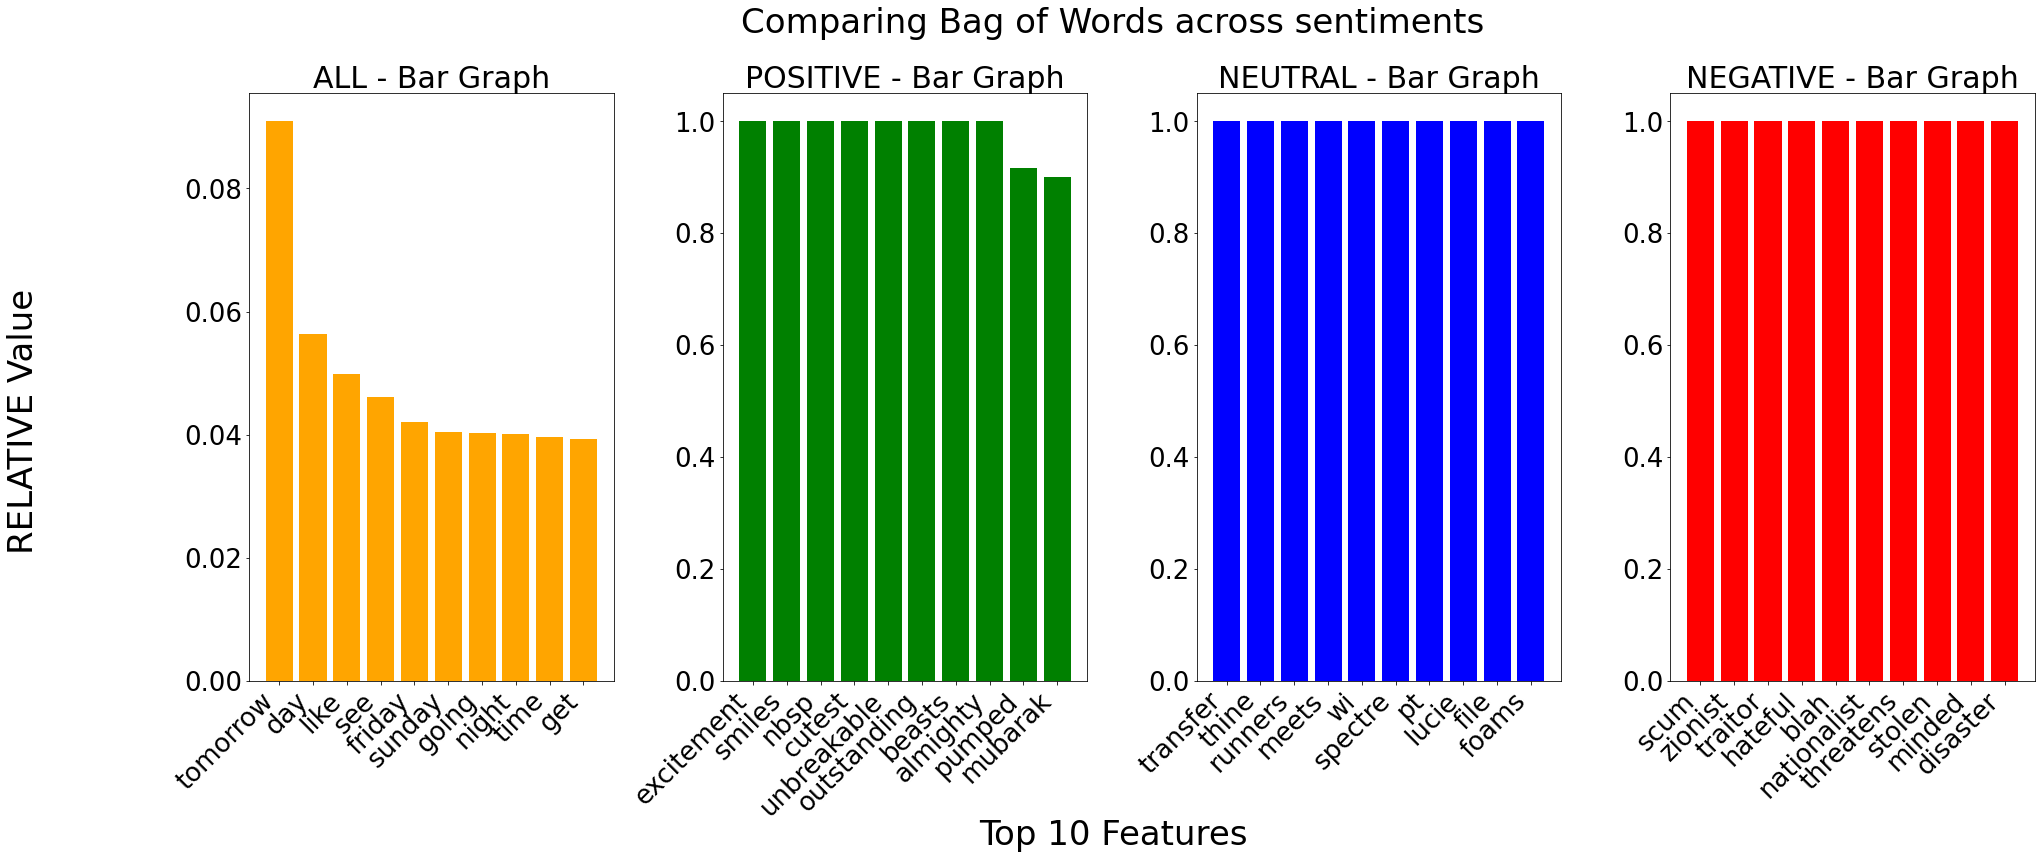

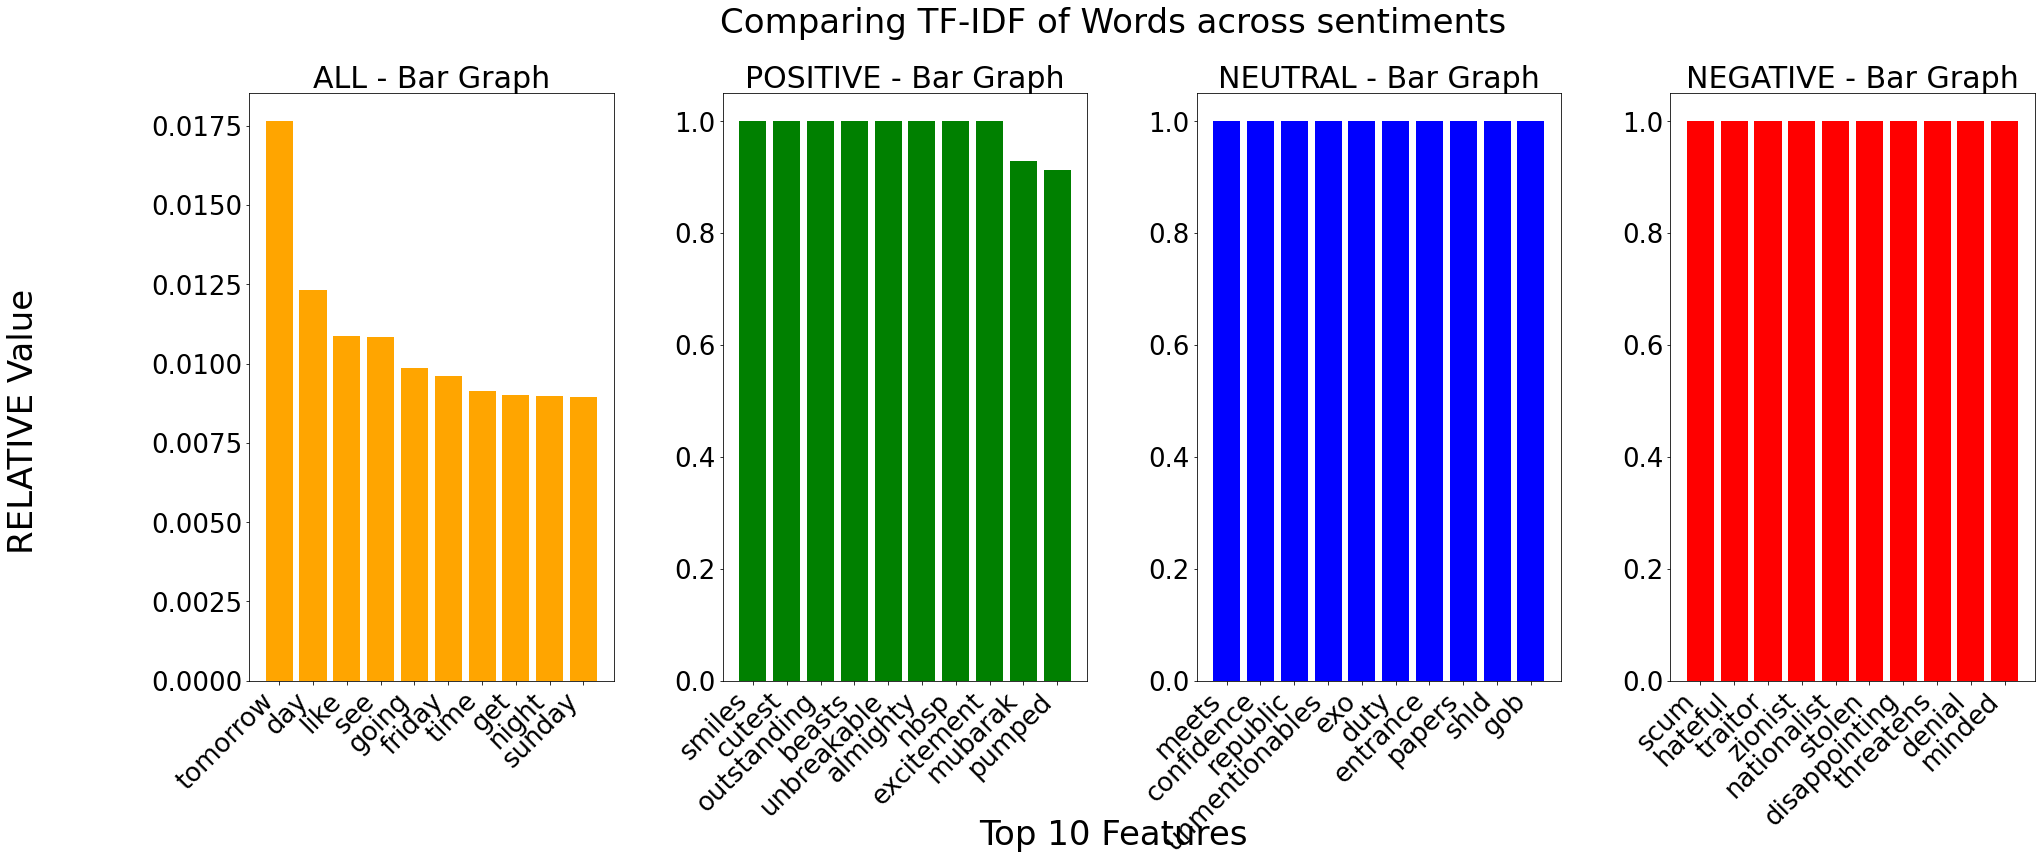

In [15]:
# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORDS_COUNT = 'Bag of Words'
cv_w = CountVectorizer(max_features=MAX_FEATURES)
X_train_features[FEATURE_WORDS_COUNT] = cv_w.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORDS_COUNT] = cv_w.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORDS_COUNT], y, cv_w.get_feature_names_out(), FEATURE_WORDS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_WORDS_TFIDF = 'TF-IDF of Words'
tfidf_w = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_features[FEATURE_WORDS_TFIDF] = tfidf_w.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORDS_TFIDF] = tfidf_w.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORDS_TFIDF], y, tfidf_w.get_feature_names_out(), FEATURE_WORDS_TFIDF)

### Part-of-speech Tags

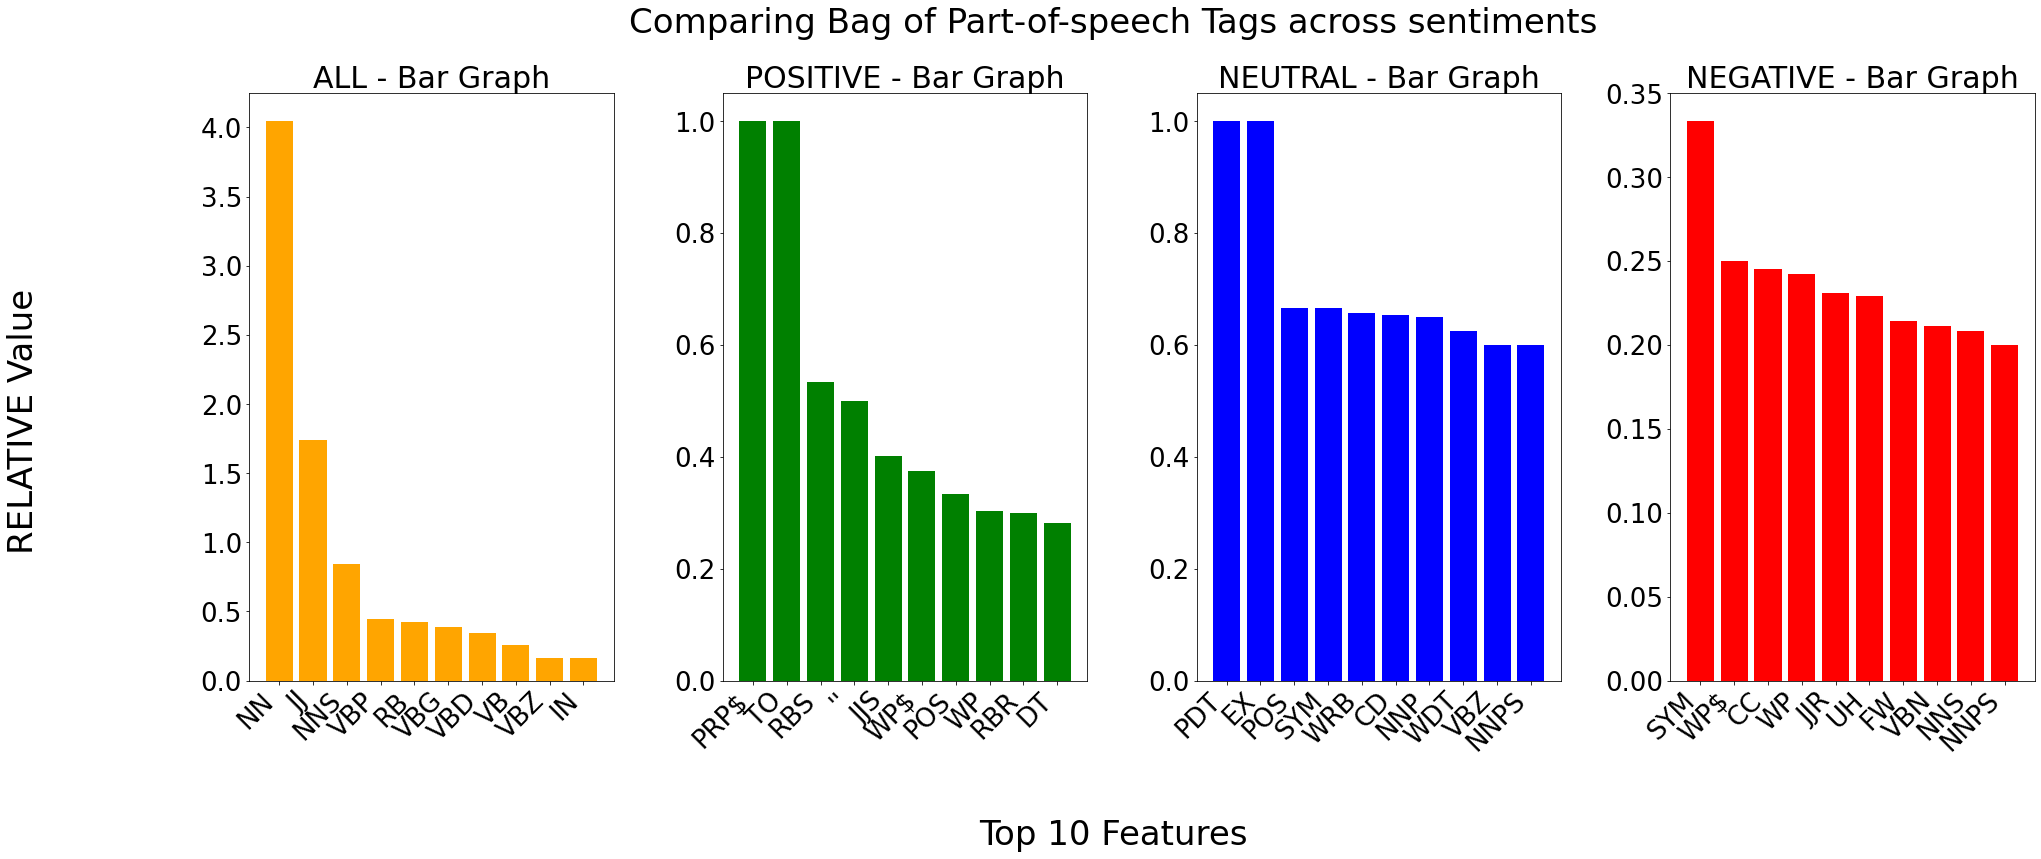

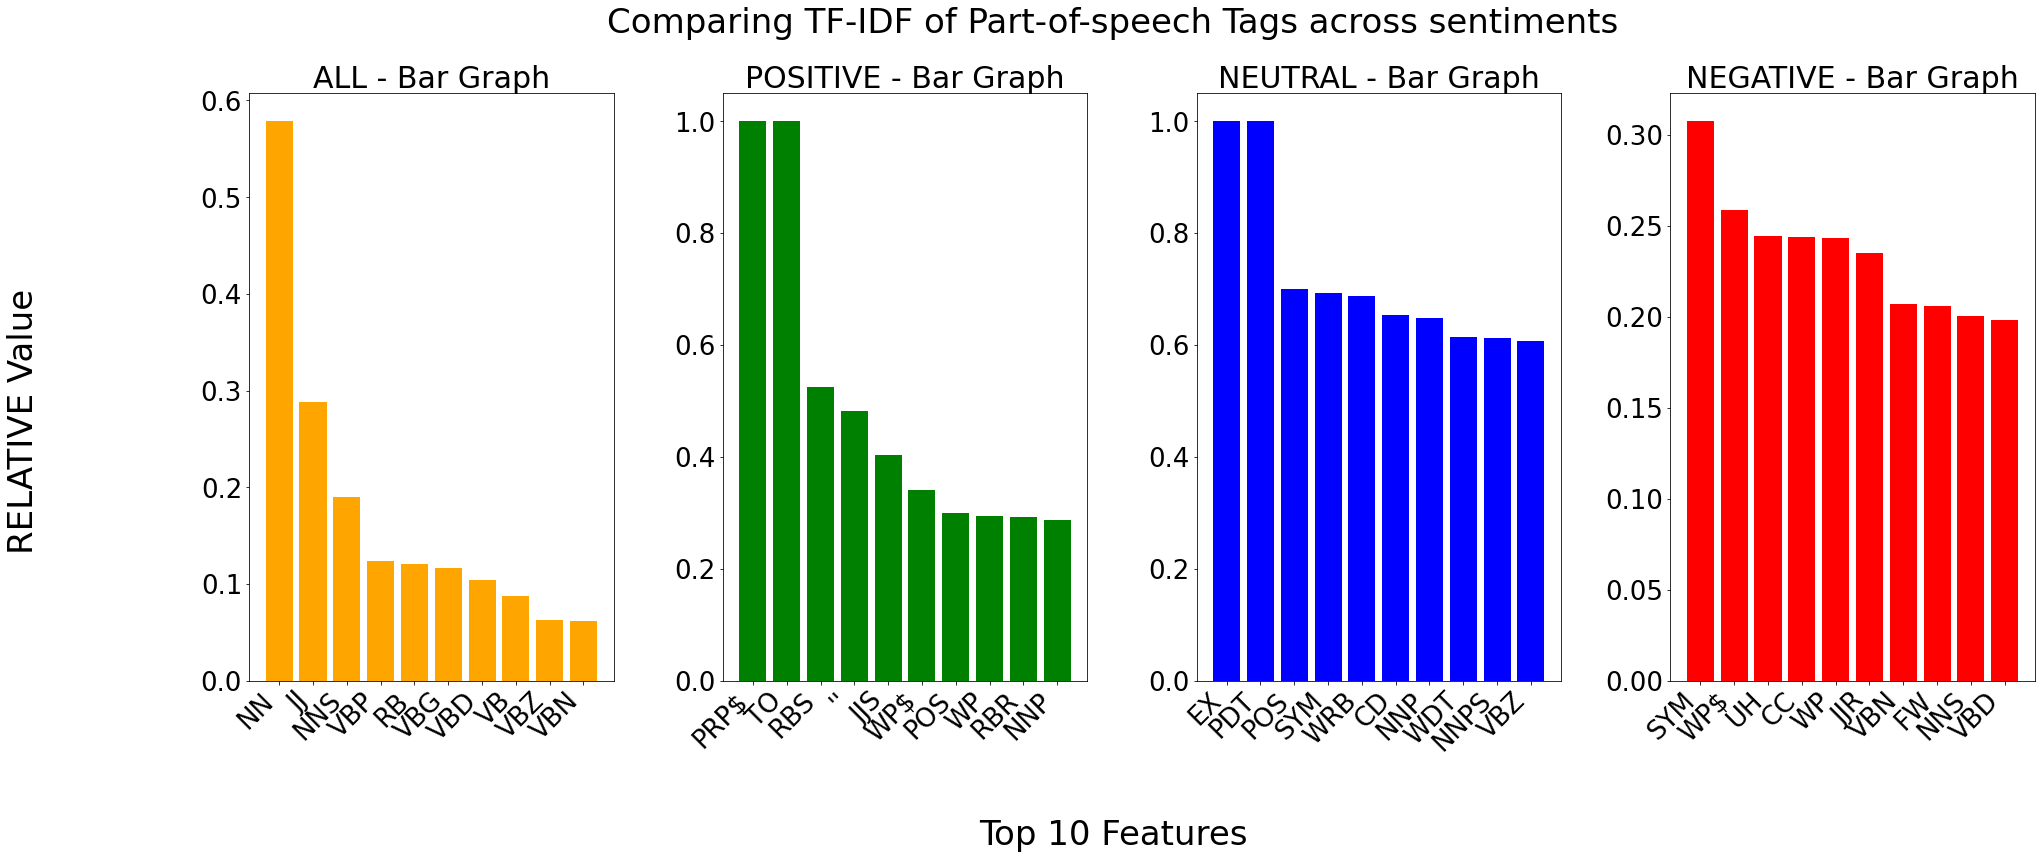

In [16]:
# Define the tags list
def tokenizer_pos(tweet): return [t[1] for t in nltk.pos_tag(tweet.split(' '))]

# test the stemming split tokenization on the count/bag-of-words
FEATURE_POS_TAGS_COUNT = 'Bag of Part-of-speech Tags'
cv_pos = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
X_train_features[FEATURE_POS_TAGS_COUNT] = cv_pos.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_POS_TAGS_COUNT] = cv_pos.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_POS_TAGS_COUNT], y, cv_pos.get_feature_names_out(), FEATURE_POS_TAGS_COUNT)

# test the stemming split tokenization on the tf-idf
FEATURE_POS_TAGS_TFIDF = 'TF-IDF of Part-of-speech Tags'
tfidf_pos = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
X_train_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_POS_TAGS_TFIDF], y, tfidf_pos.get_feature_names_out(), FEATURE_POS_TAGS_TFIDF)

### Stems

In [17]:
if False: # stemming not needed
    # Porter Stemmer
    ps = PorterStemmer()
    def tokenizer_stem(tweet): return [ps.stem(w) for w in tweet.split(' ')]

    # test the stemming split tokenization on the count/bag-of-words
    FEATURE_STEMS_COUNT = 'Bag of English Stemmed Words'
    cv_ps = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEMS_COUNT] = cv_ps.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEMS_COUNT] = cv_ps.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEMS_COUNT], y, cv_ps.get_feature_names_out(), FEATURE_STEMS_COUNT)

    # test the stemming split tokenization on the tf-idf
    FEATURE_STEMS_TFIDF = 'TF-IDF of English Stemmed Words'
    tfidf_ps = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEMS_TFIDF] = tfidf_ps.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEMS_TFIDF] = tfidf_ps.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEMS_TFIDF], y, tfidf_ps.get_feature_names_out(), FEATURE_STEMS_TFIDF)

### 2-Grams

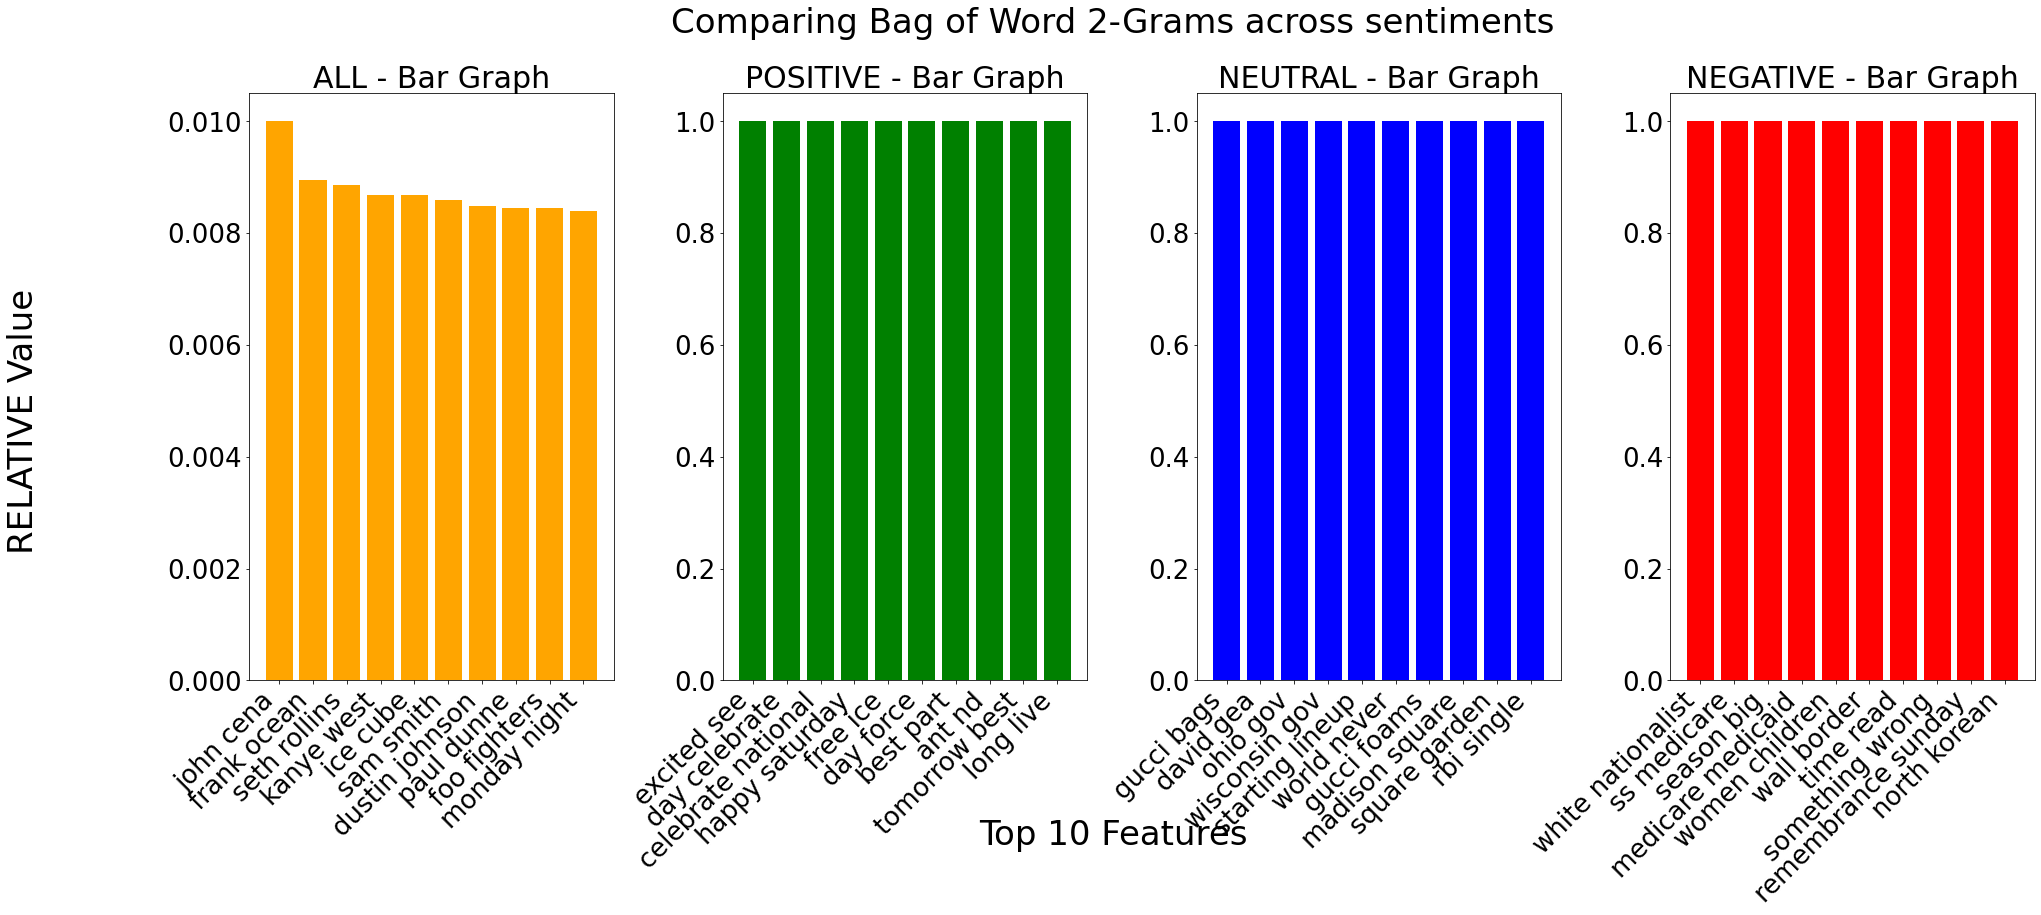

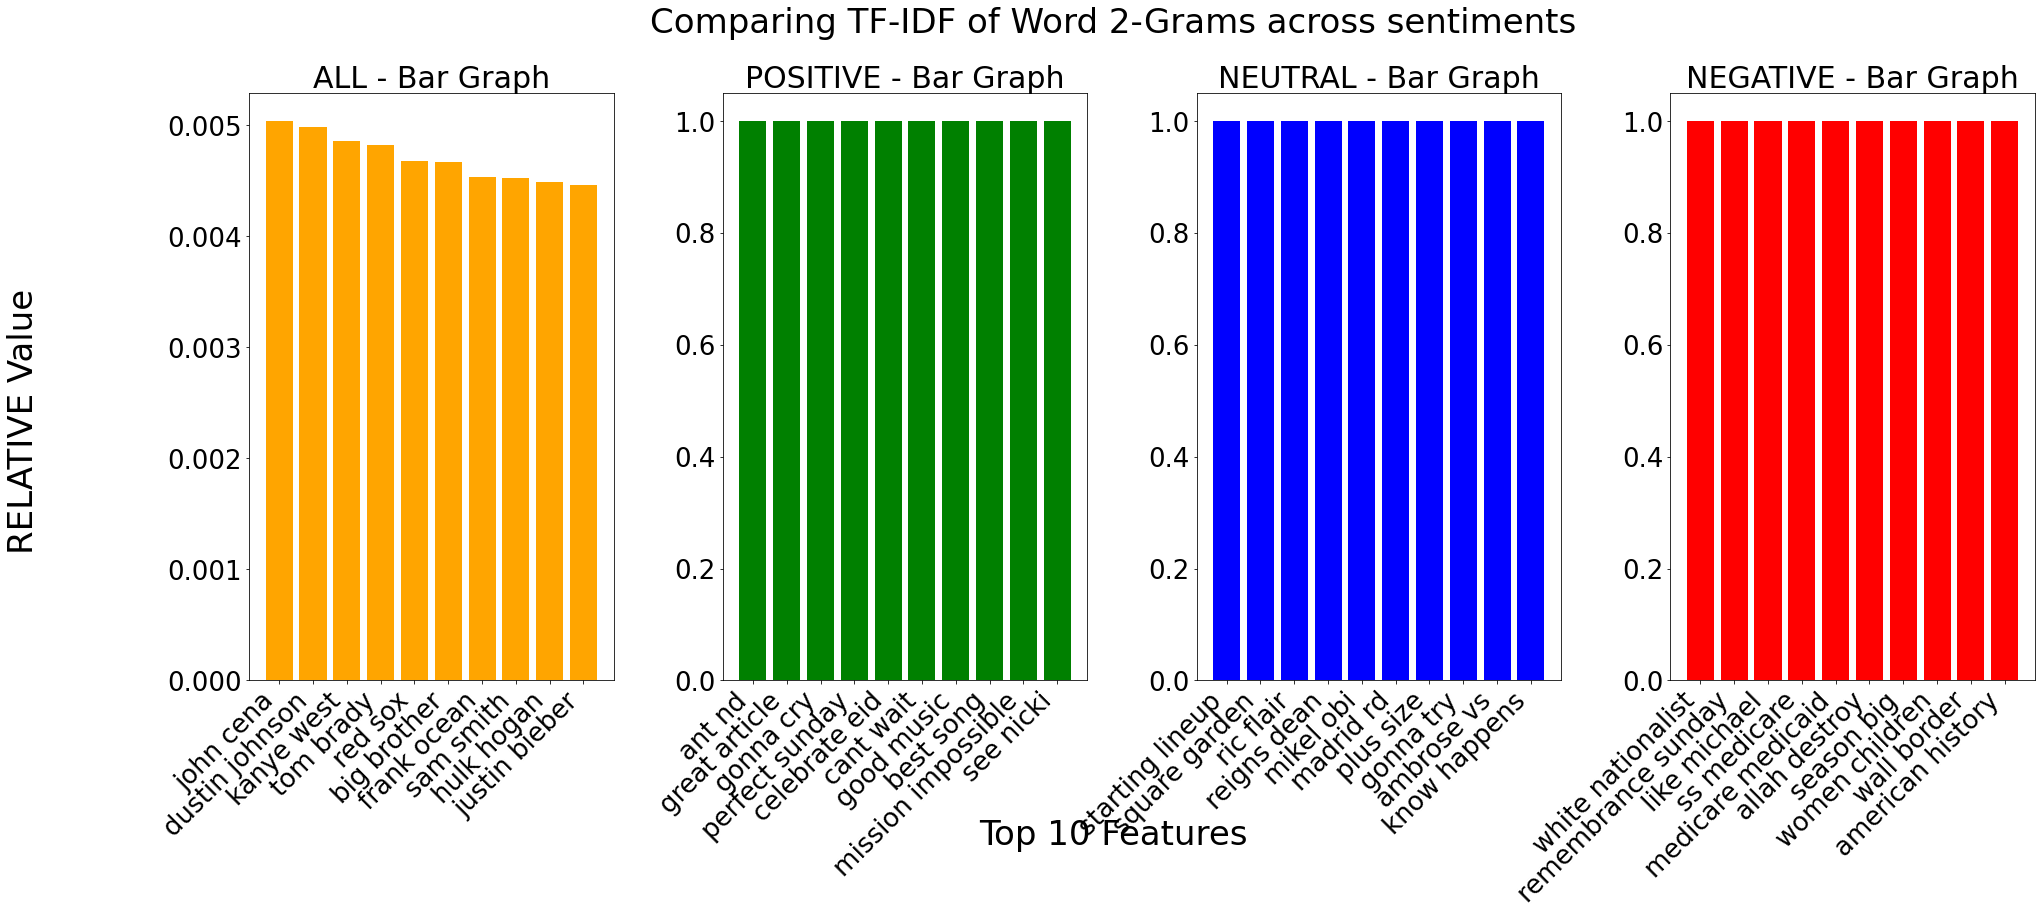

In [18]:
# Test on occurrences
FEATURE_WORD_2GRAMS_COUNT = 'Bag of Word 2-Grams'
cv_word2g = CountVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
X_train_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_2GRAMS_COUNT], y, cv_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_COUNT)

# Test on tfidf
FEATURE_WORD_2GRAMS_TFIDF = 'TF-IDF of Word 2-Grams'
tfidf_word2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
X_train_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_2GRAMS_TFIDF], y, tfidf_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_TFIDF)

if False: # stemming not needed
    # tokenizer by stemming instead
    # Test on occurrences
    FEATURE_STEM_2GRAMS_COUNT = 'Bag of English Stemmed 2-Grams'
    cv_stem2g = CountVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_COUNT], y, cv_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_COUNT)

    # Test on tfidf
    FEATURE_STEM_2GRAMS_TFIDF = 'TF-IDF of English Stemmed 2-Grams'
    tfidf_stem2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_TFIDF], y, tfidf_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_TFIDF)

### Characters

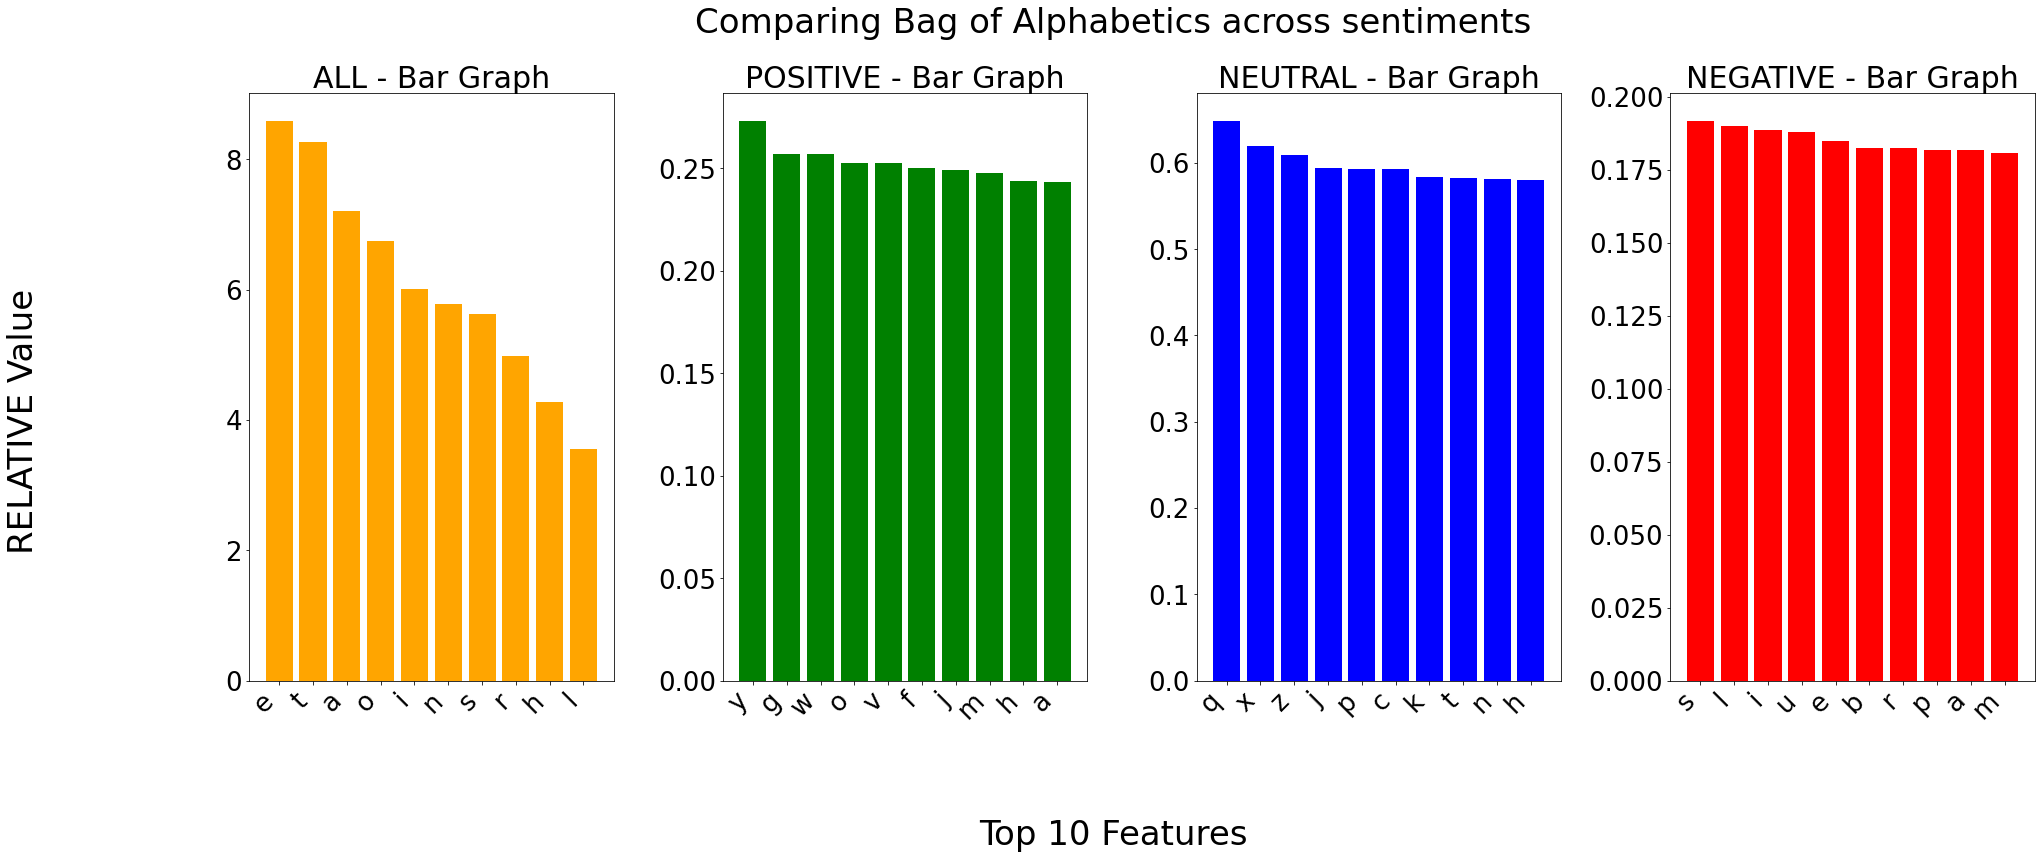

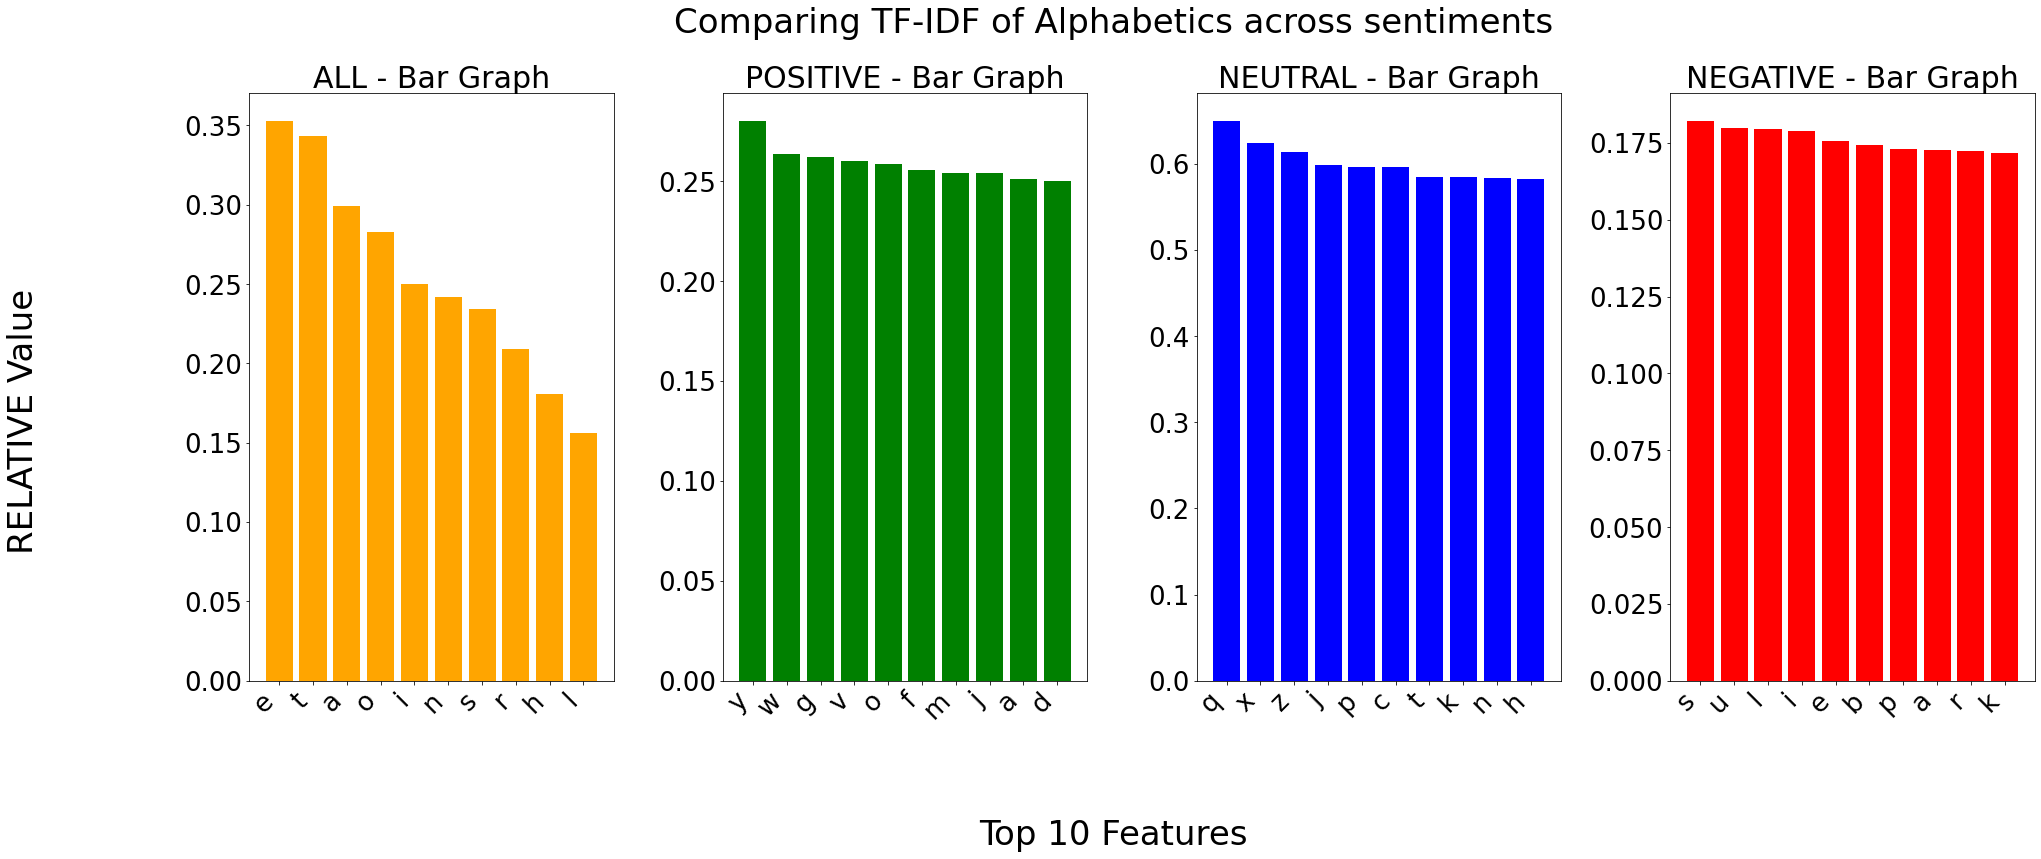

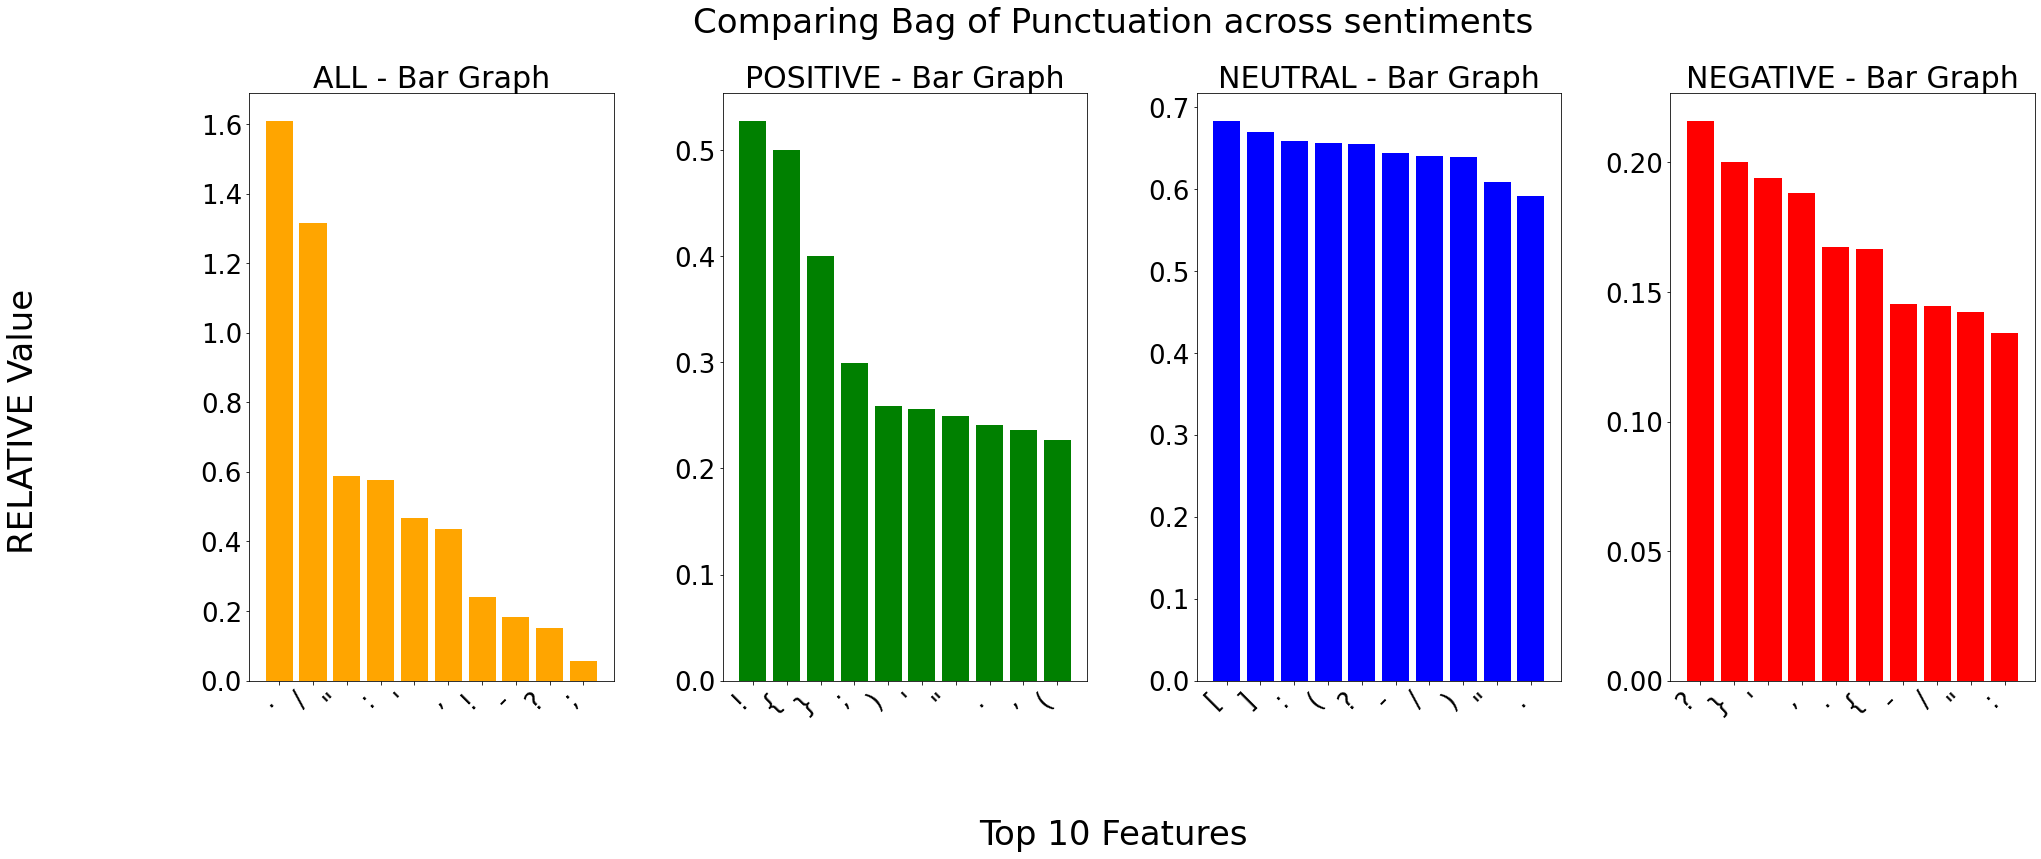

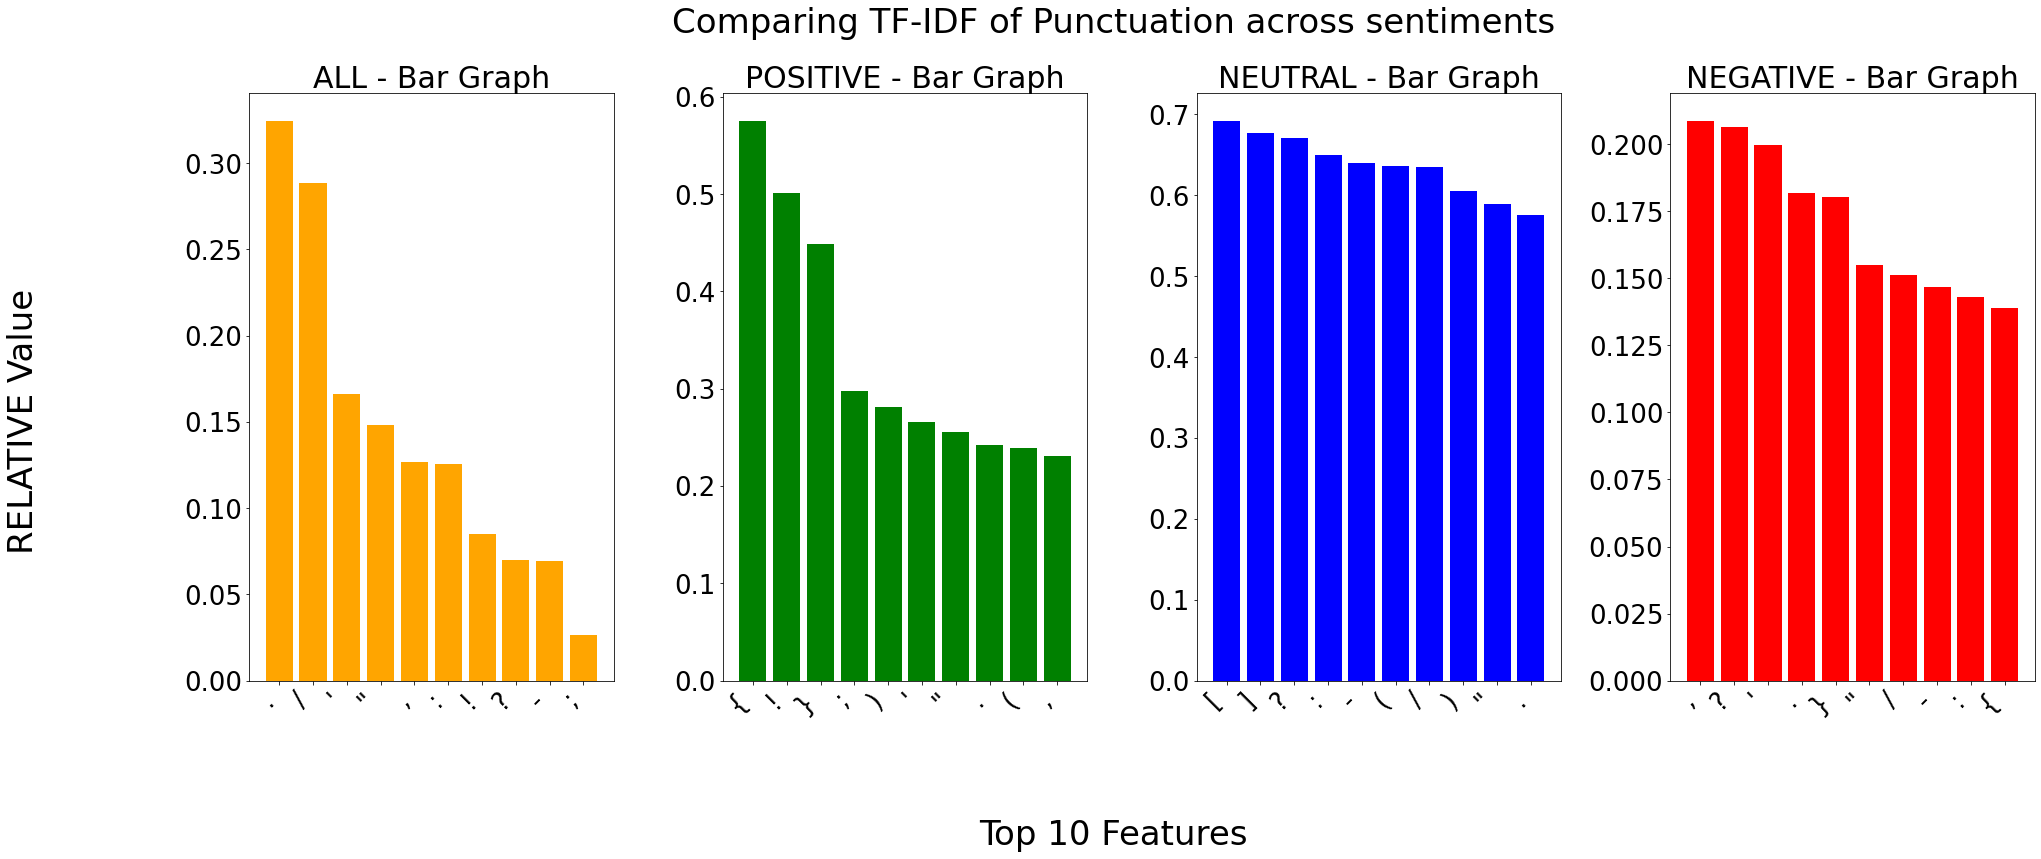

In [19]:
def tokenizer_char(tweet, char_type = 'alphabetic'): 
    if char_type == 'alphabetic':
        t = re.sub(r'[^a-z]+', '', tweet)
        return list(t)
    elif char_type == 'non-word':
        t = re.sub(r'[\w\s]+', '', tweet)
        return list(t)
    elif char_type == 'punctuation':
        return RE_PUNCTUATION.findall(tweet)
    else:
        return list(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_ALPHABETICS_COUNT = 'Bag of Alphabetics'
cv_alpha = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
X_train_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.fit_transform(train_df['text'])
X_test_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_ALPHABETICS_COUNT], y, cv_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_ALPHABETICS_TFIDF = 'TF-IDF of Alphabetics'
tfidf_alpha = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
X_train_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.fit_transform(train_df['text'])
X_test_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_ALPHABETICS_TFIDF], y, tfidf_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PUNCTUATION_COUNT = 'Bag of Punctuation'
cv_punct = CountVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
X_train_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.fit_transform(train_df['text'])
X_test_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_PUNCTUATION_COUNT], y, cv_punct.get_feature_names_out(), FEATURE_PUNCTUATION_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PUNCTUATION_TFIDF = 'TF-IDF of Punctuation'
tfidf_punct = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
X_train_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.fit_transform(train_df['text'])
X_test_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_PUNCTUATION_TFIDF], y, tfidf_punct.get_feature_names_out(), FEATURE_PUNCTUATION_TFIDF)

### Word Lengths

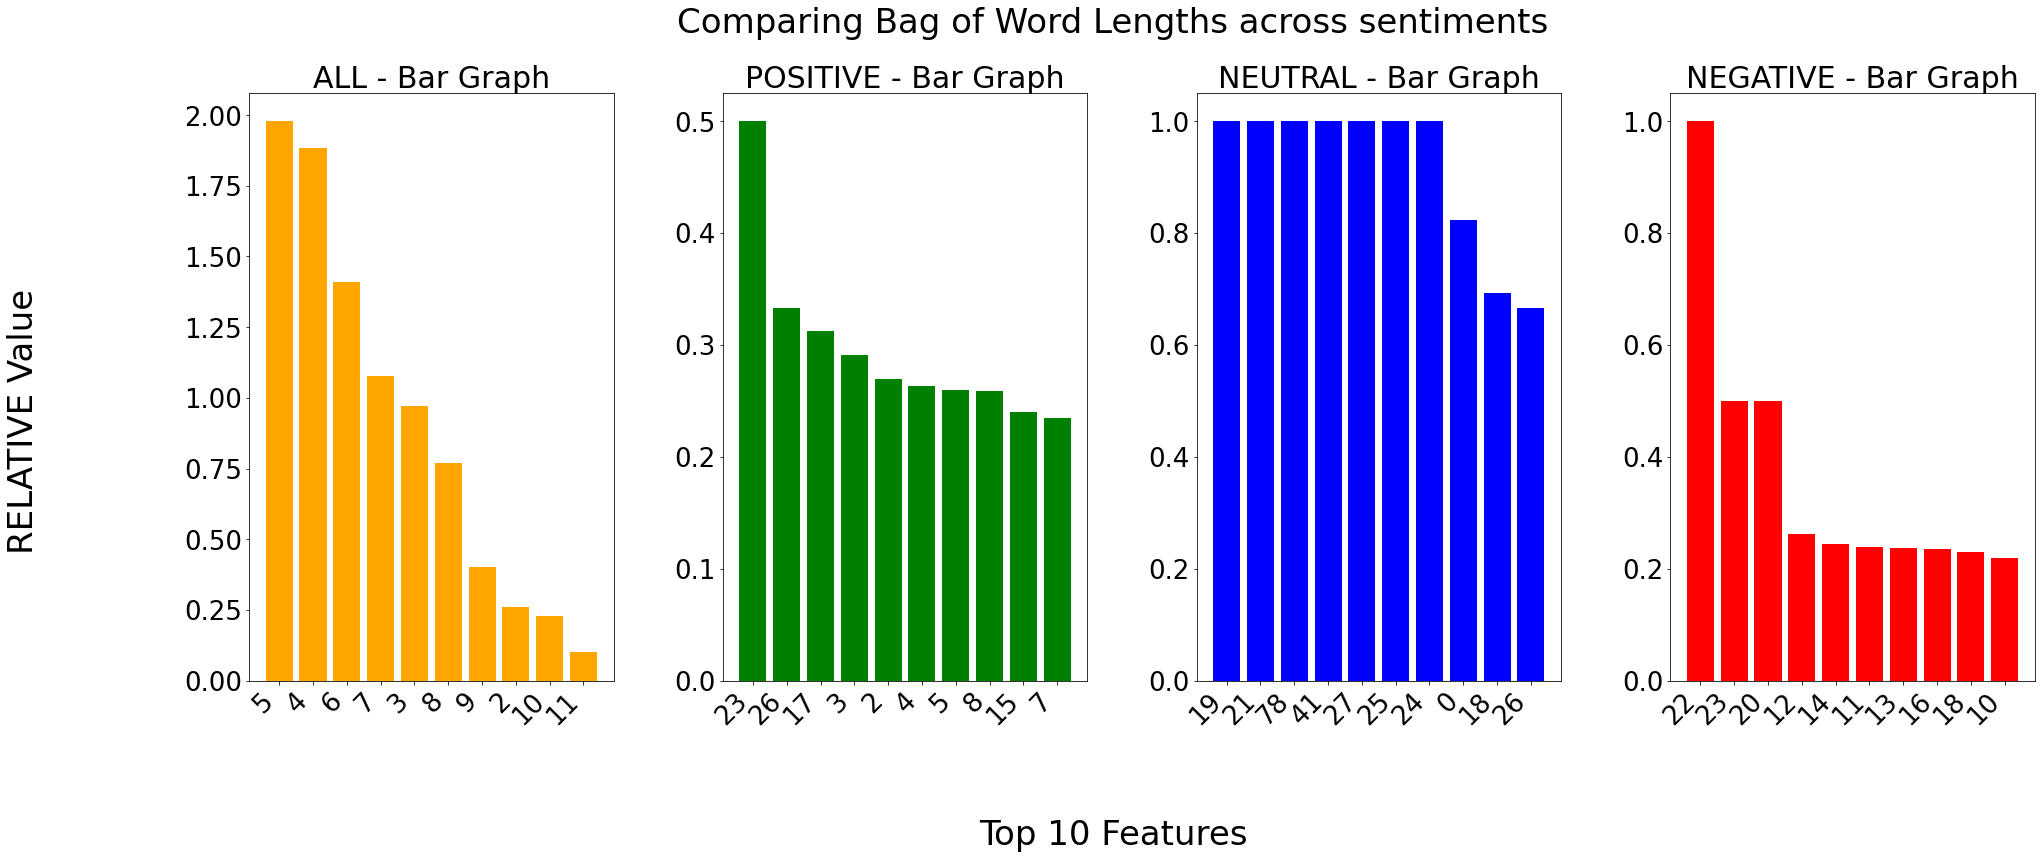

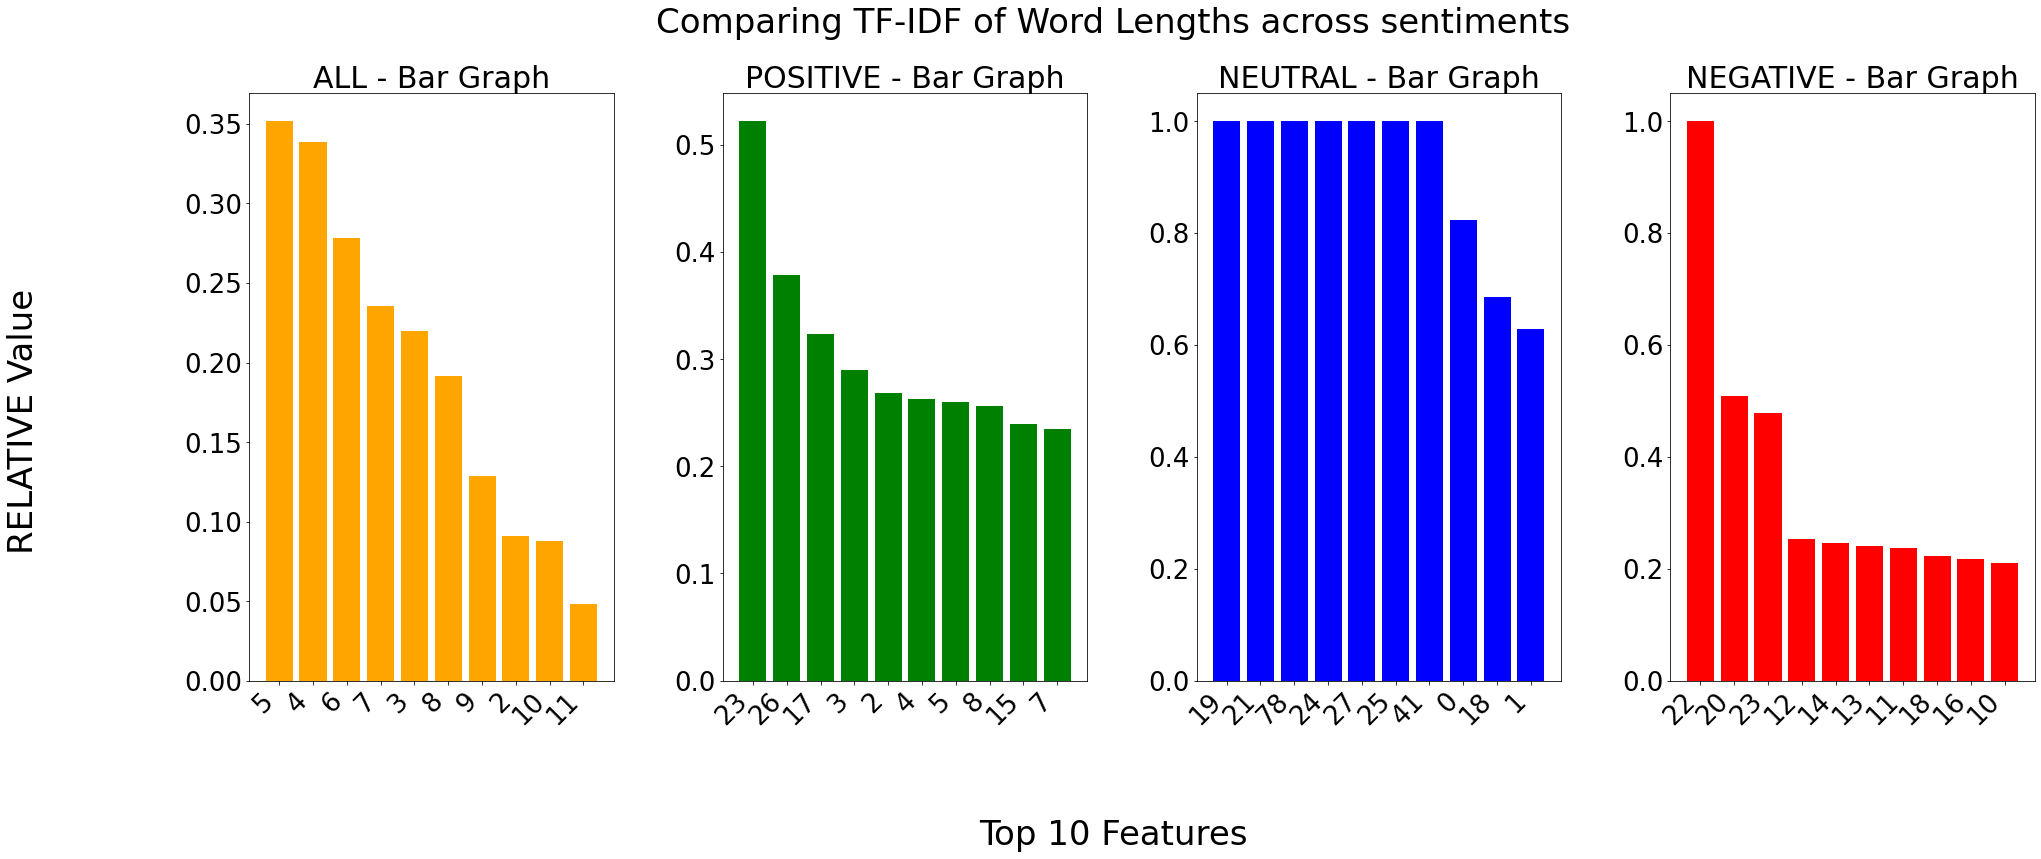

In [20]:
def tokenizer_word_lengths(tweet): return [f'{len(w)}' for w in tweet.split(' ')]

# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORD_LENGTHS_TFIDF = 'Bag of Word Lengths'
cv_wl = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = cv_wl.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = cv_wl.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, cv_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

# test the regular word split tokenization on the tf-idf
FEATURE_WORD_LENGTHS_TFIDF = 'TF-IDF of Word Lengths'
tfidf_wl = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, tfidf_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

### Links

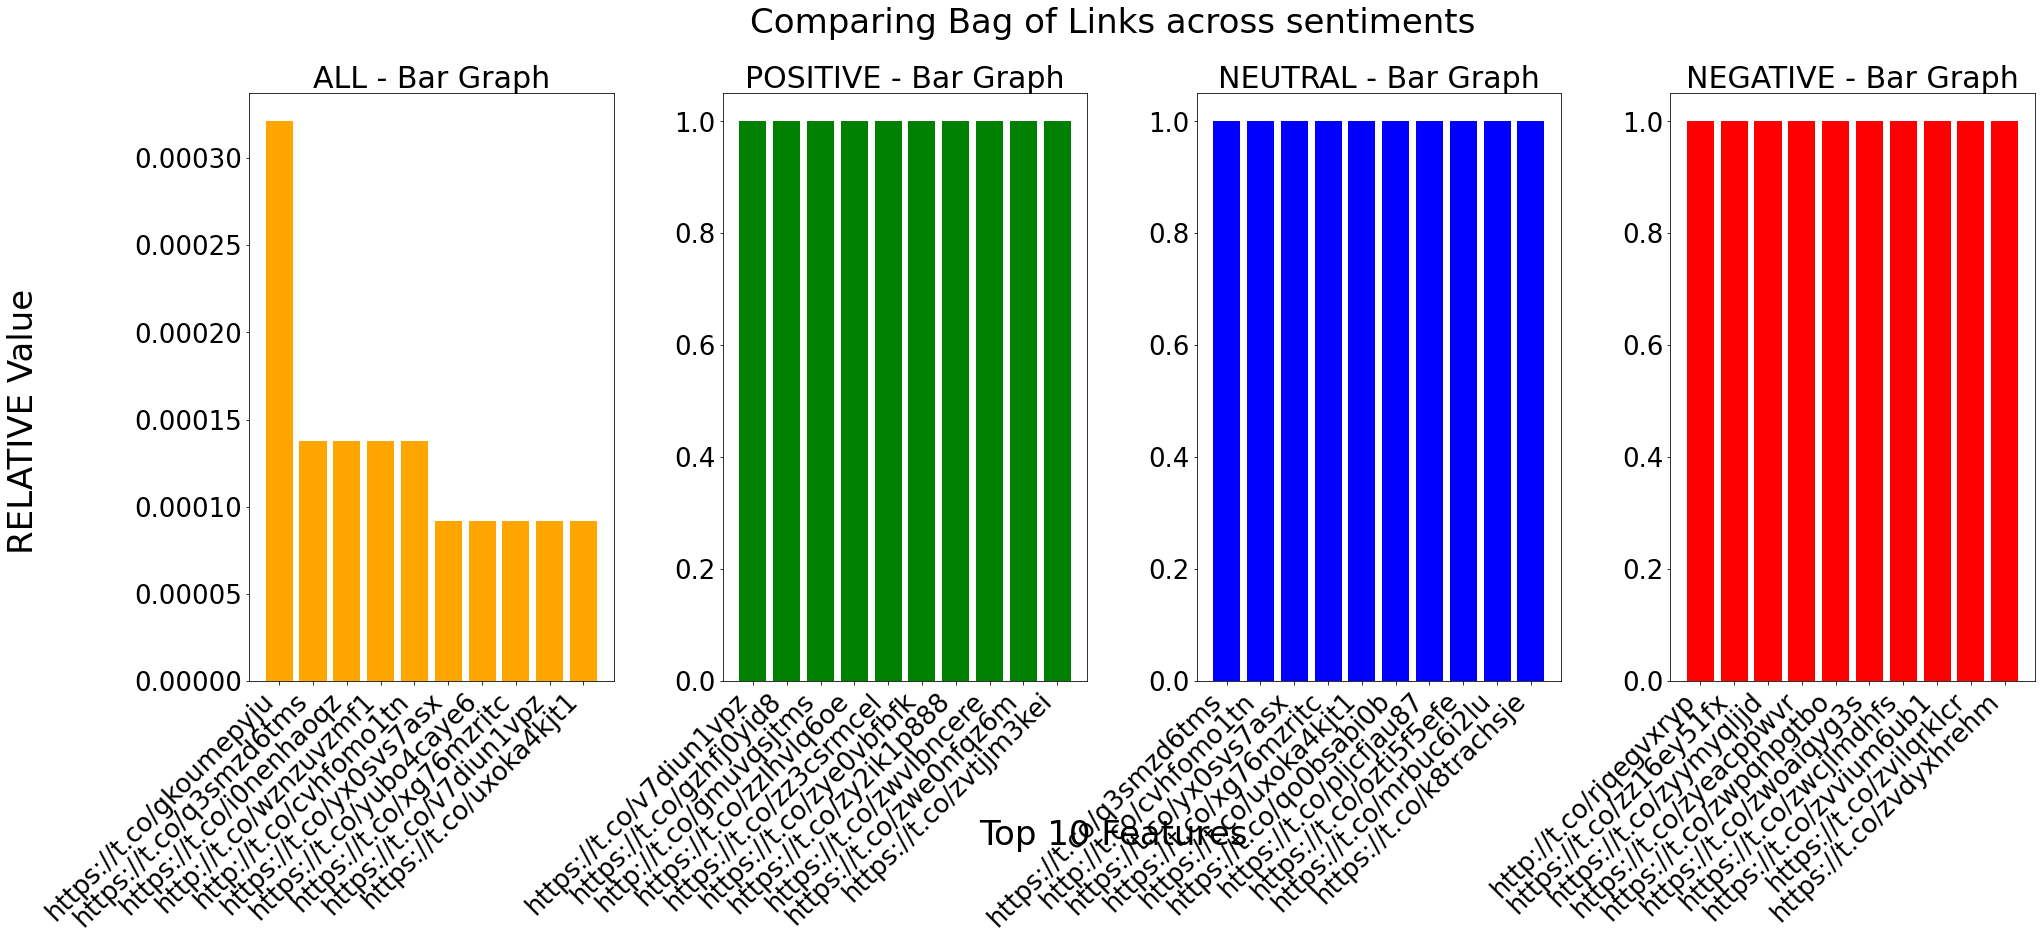

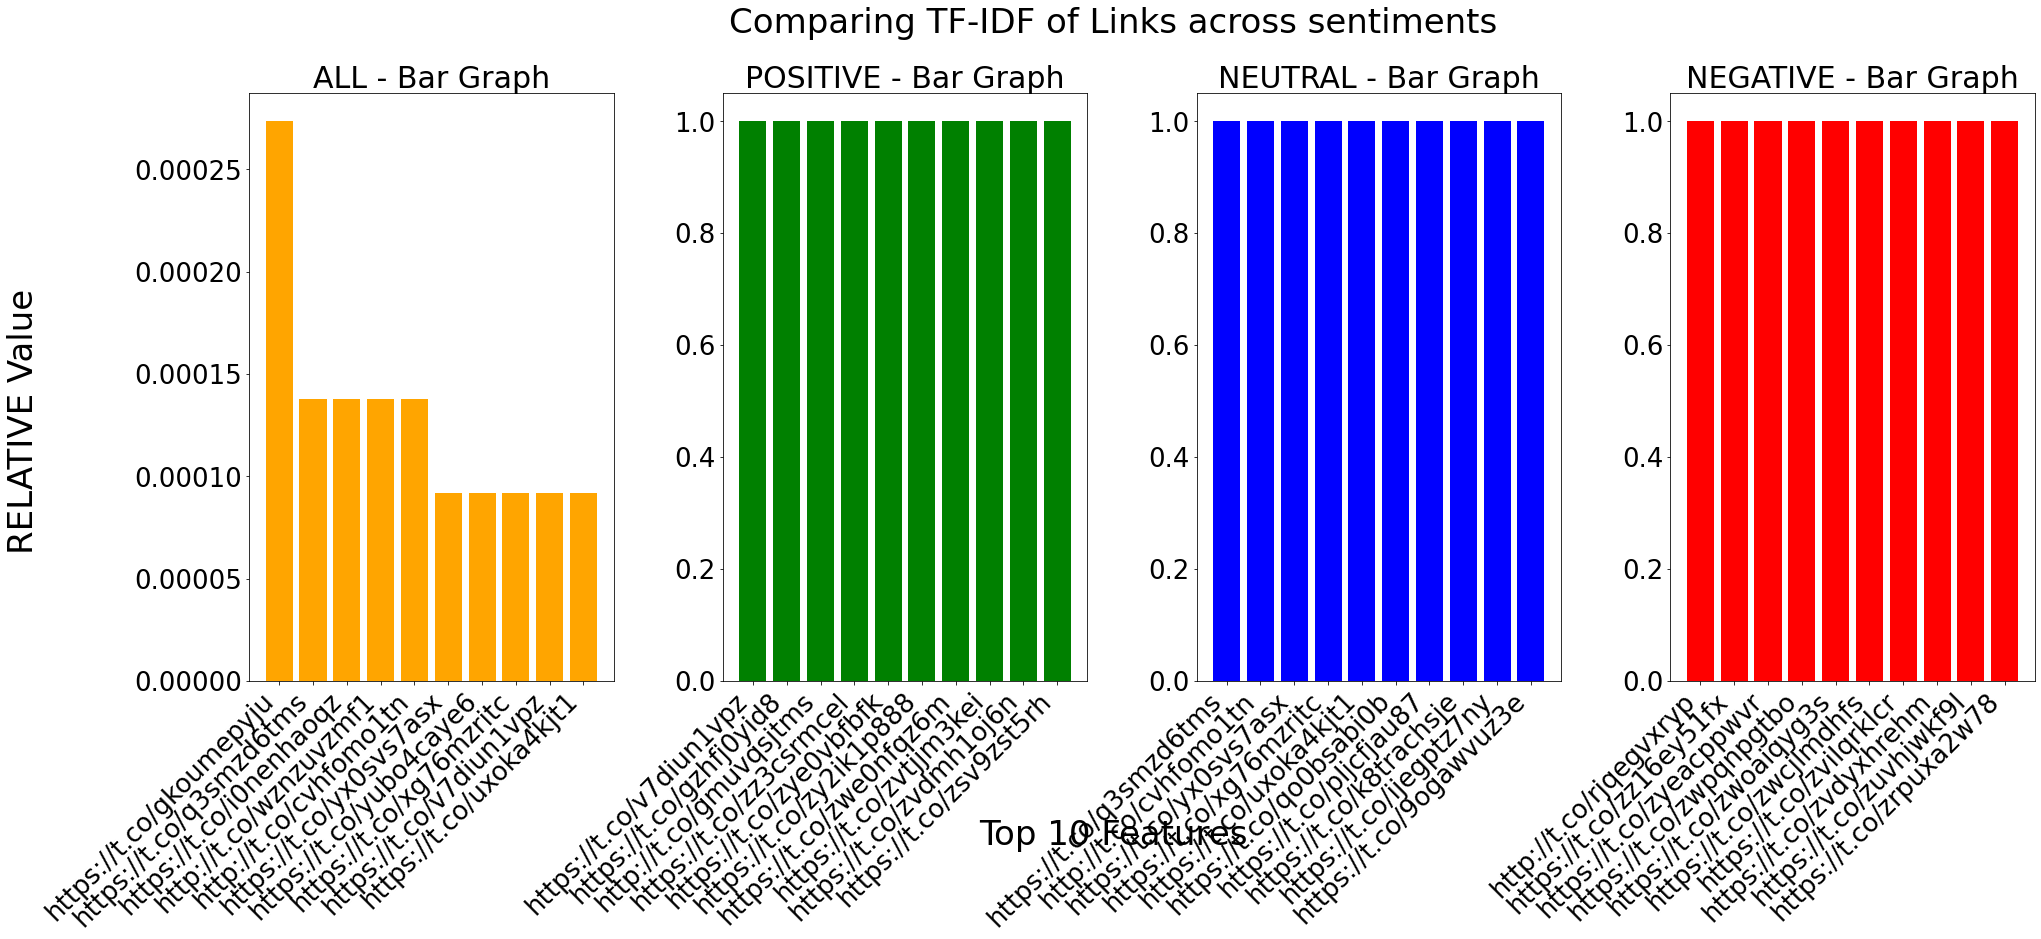

In [21]:
def tokenizer_links(tweet): return RE_LINKS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_LINKS_COUNT = 'Bag of Links'
cv_link = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
X_train_features[FEATURE_LINKS_COUNT] = cv_link.fit_transform(train_df['text'])
X_test_features[FEATURE_LINKS_COUNT] = cv_link.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_LINKS_COUNT], y, cv_link.get_feature_names_out(), FEATURE_LINKS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_LINKS_TFIDF = 'TF-IDF of Links'
tfidf_link = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
X_train_features[FEATURE_LINKS_TFIDF] = tfidf_link.fit_transform(train_df['text'])
X_test_features[FEATURE_LINKS_TFIDF] = tfidf_link.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_LINKS_TFIDF], y, tfidf_link.get_feature_names_out(), FEATURE_LINKS_TFIDF)

### Hashtags

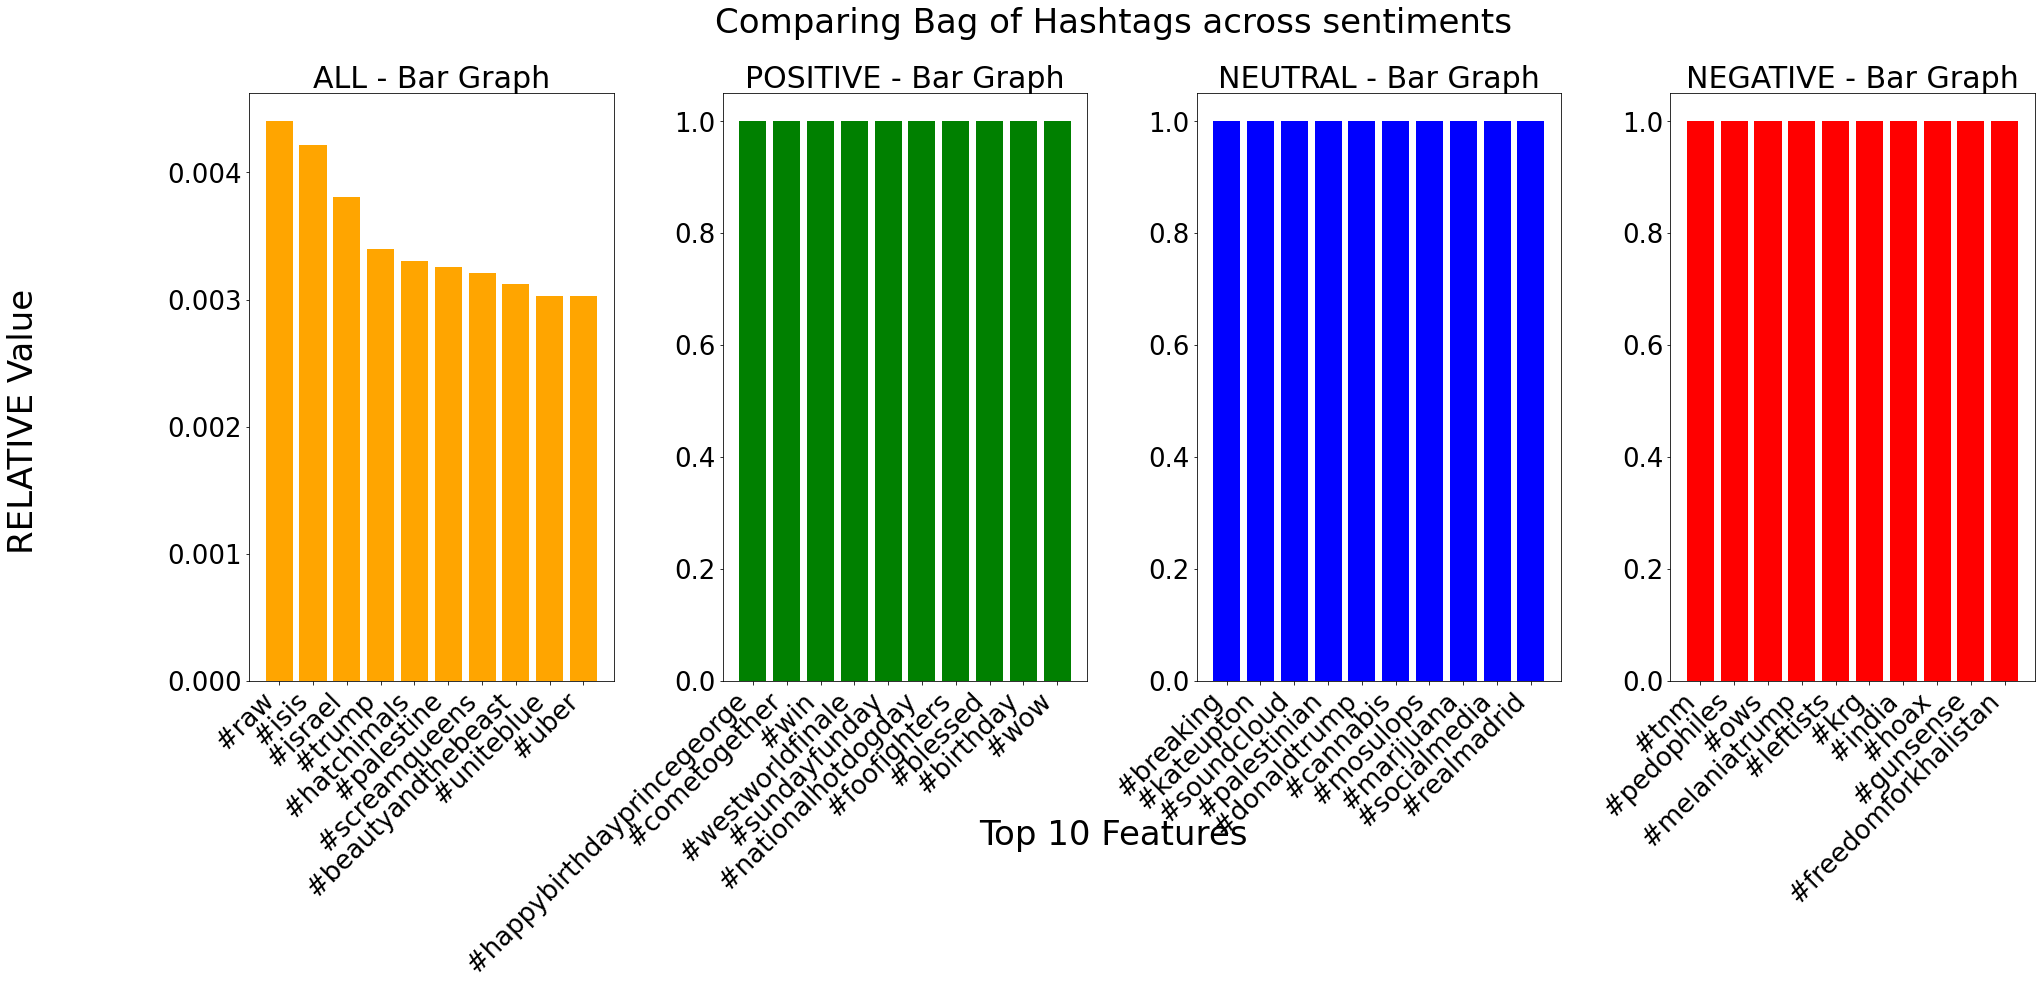

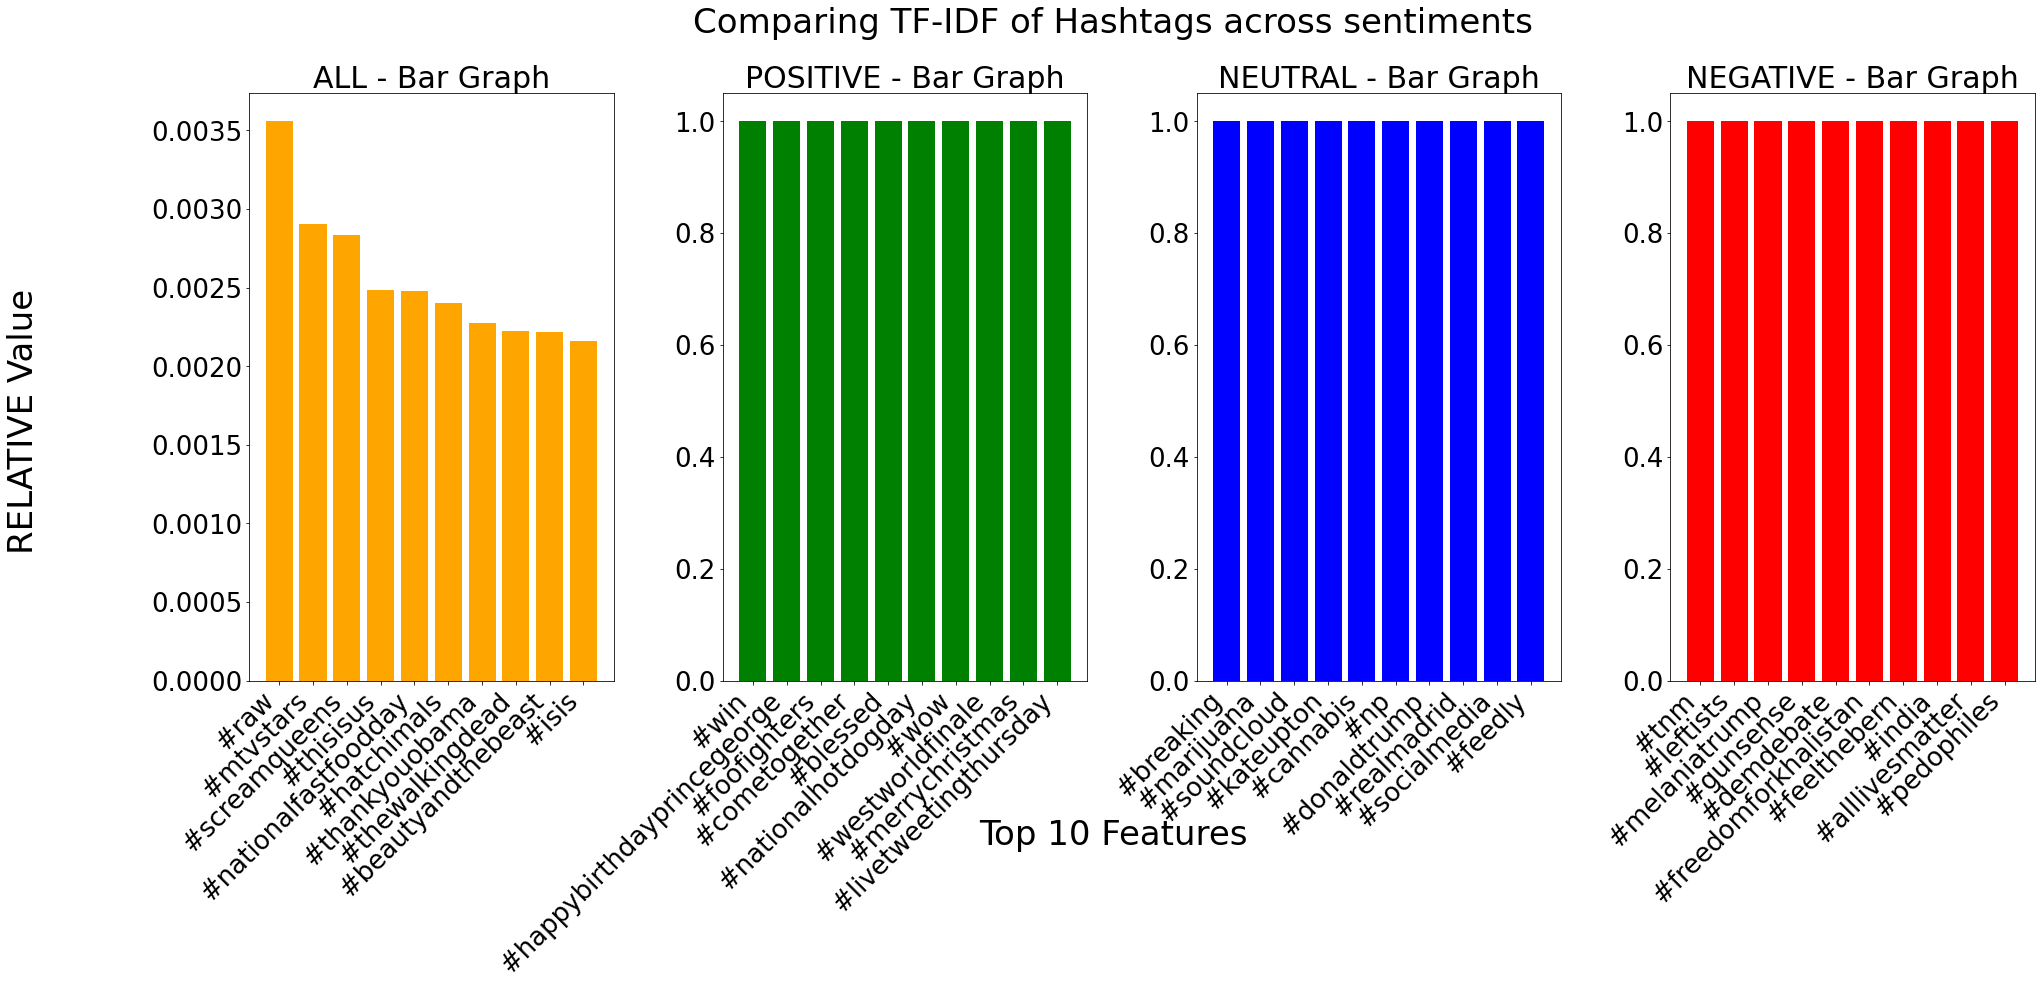

In [22]:
def tokenizer_hashtags(tweet): return RE_HASHTAGS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_HASHTAGS_COUNT = 'Bag of Hashtags'
cv_ht = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
X_train_features[FEATURE_HASHTAGS_COUNT] = cv_ht.fit_transform(train_df['text'])
X_test_features[FEATURE_HASHTAGS_COUNT] = cv_ht.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_HASHTAGS_COUNT], y, cv_ht.get_feature_names_out(), FEATURE_HASHTAGS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_HASHTAGS_TFIDF = 'TF-IDF of Hashtags'
tfidf_ht = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
X_train_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.fit_transform(train_df['text'])
X_test_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_HASHTAGS_TFIDF], y, tfidf_ht.get_feature_names_out(), FEATURE_HASHTAGS_TFIDF)

### Mentions

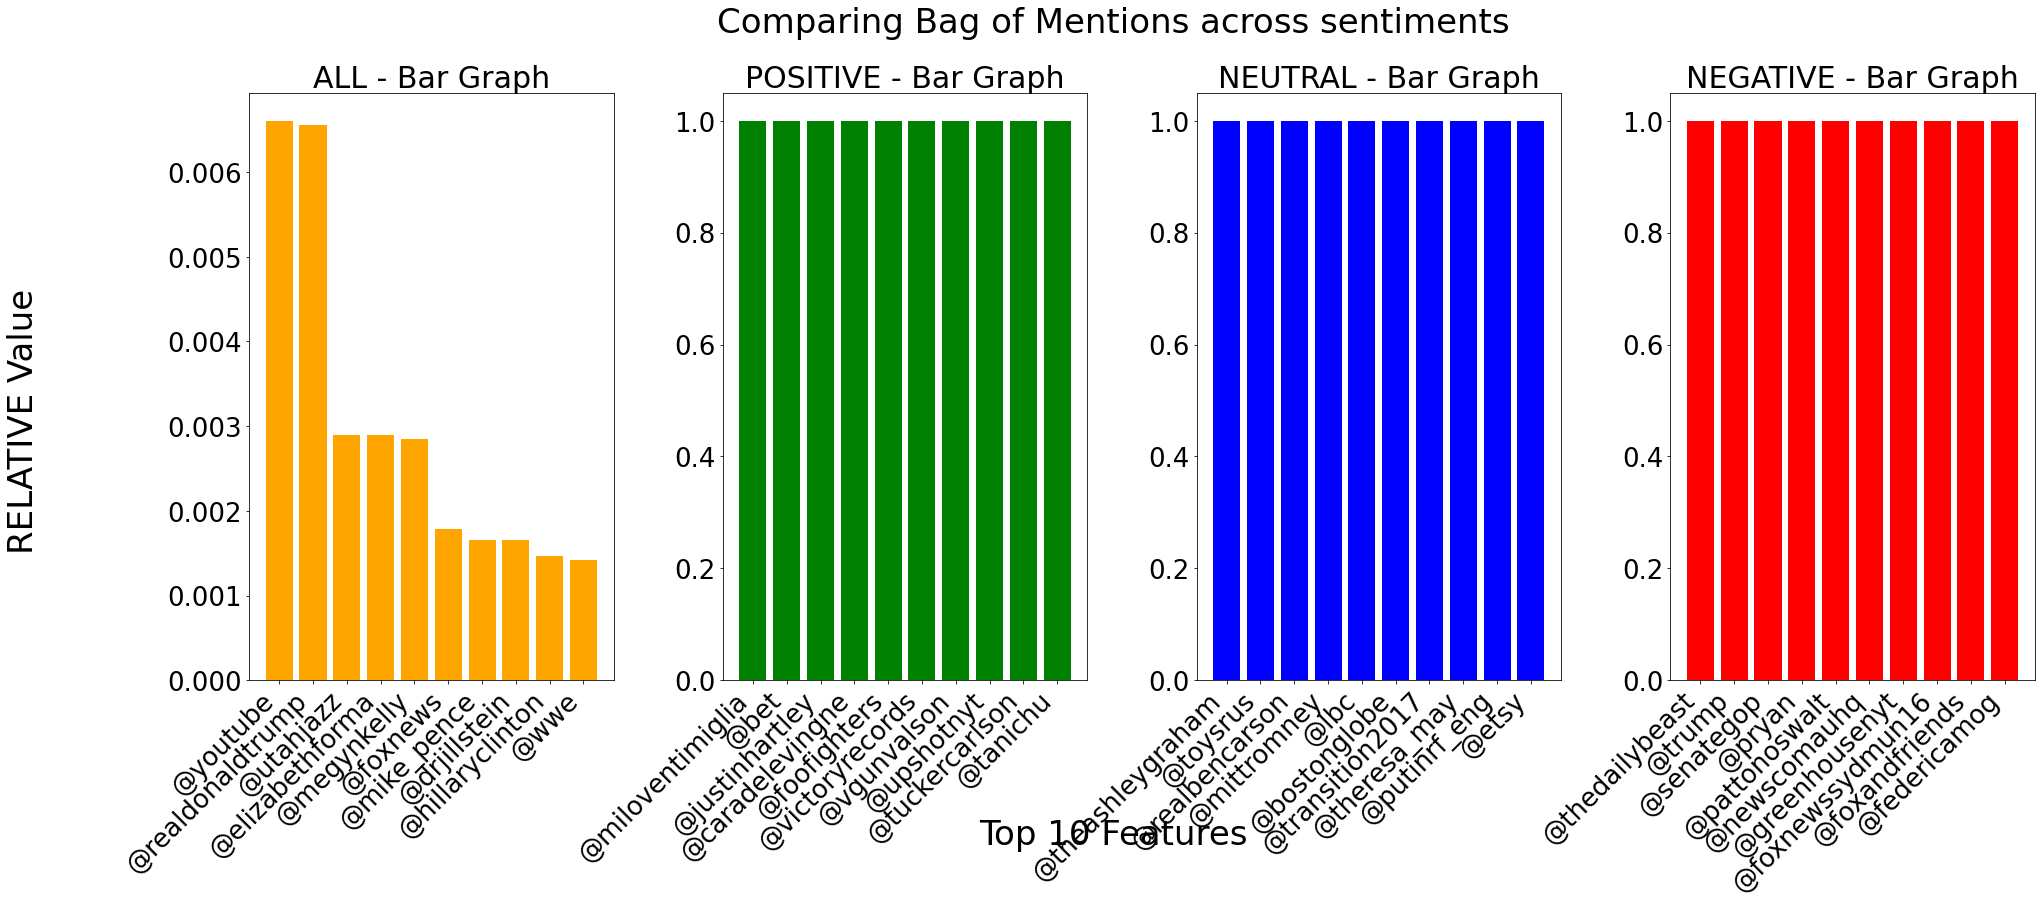

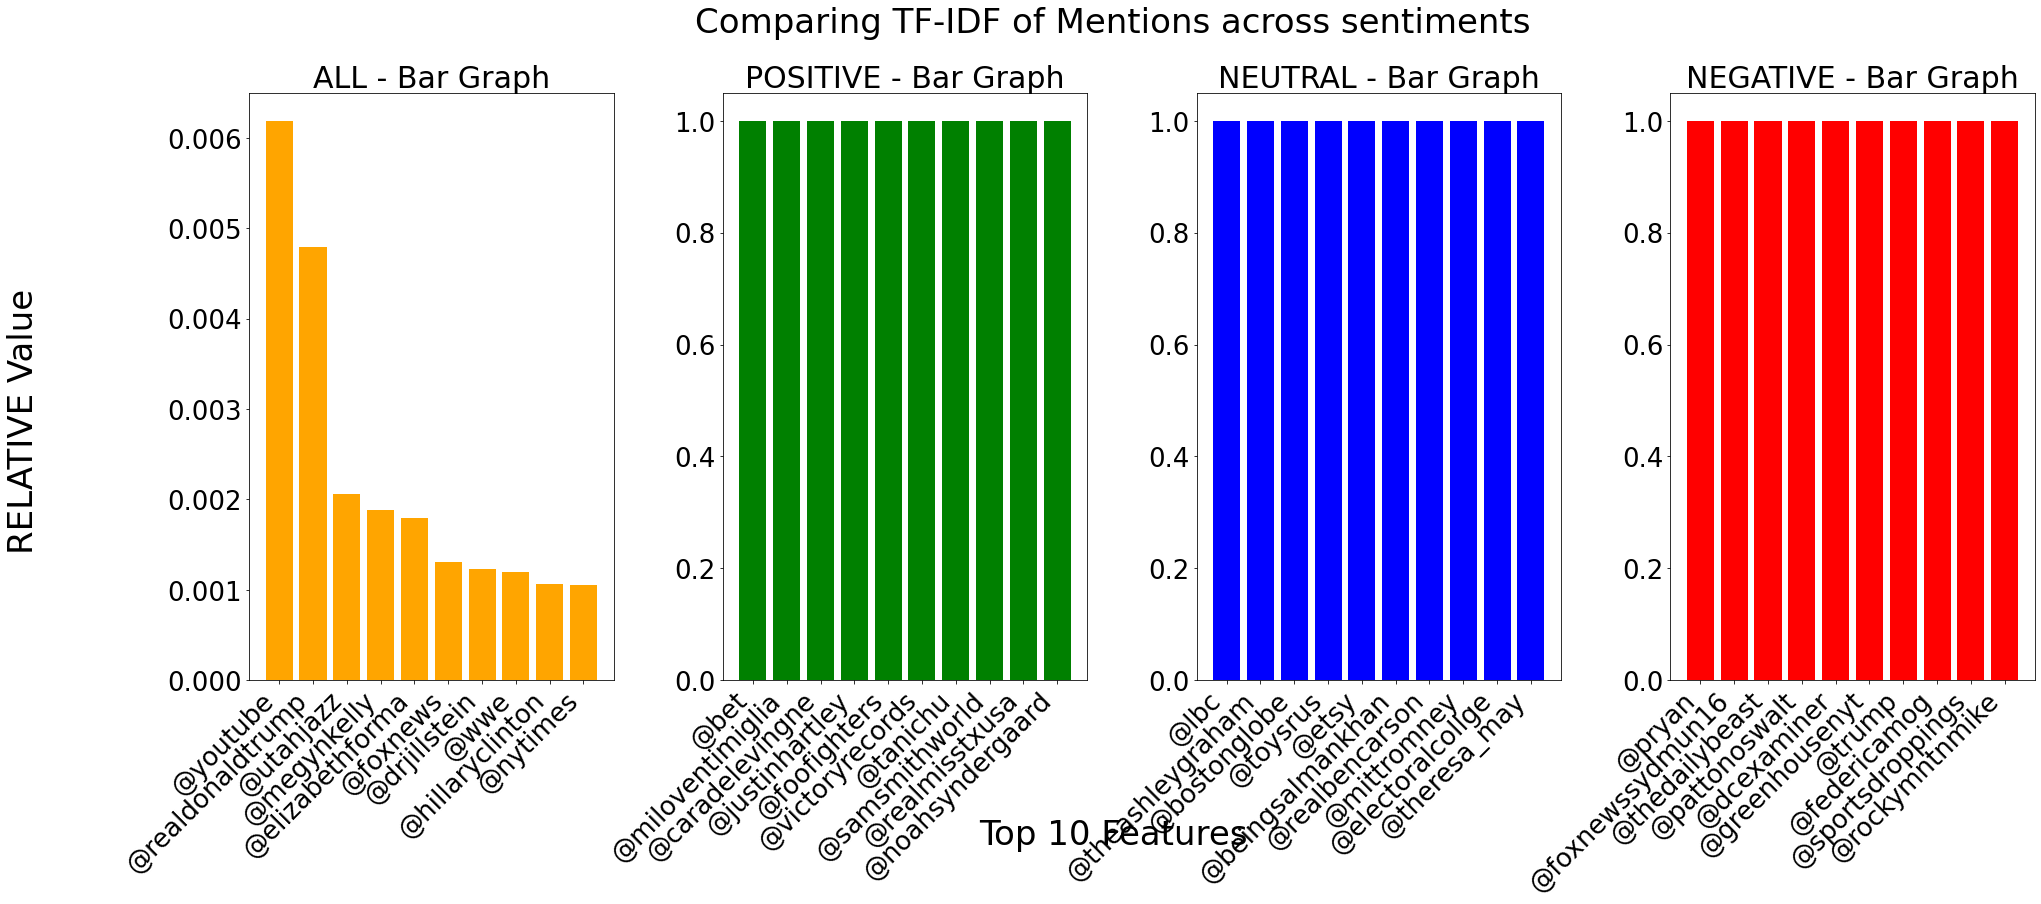

In [23]:
def tokenizer_mentions(tweet): return RE_MENTIONS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_MENTIONS_COUNT = 'Bag of Mentions'
cv_at = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions, binary=True)
X_train_features[FEATURE_MENTIONS_COUNT] = cv_at.fit_transform(train_df['text'])
X_test_features[FEATURE_MENTIONS_COUNT] = cv_at.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_MENTIONS_COUNT], y, cv_at.get_feature_names_out(), FEATURE_MENTIONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_MENTIONS_TFIDF = 'TF-IDF of Mentions'
tfidf_at = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions)
X_train_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.fit_transform(train_df['text'])
X_test_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_MENTIONS_TFIDF], y, tfidf_at.get_feature_names_out(), FEATURE_MENTIONS_TFIDF)

### Emoticons


In [24]:
# define the sets of symbols to construct the emoticons
CH_EMOTE_EYES = r';:8='  # eye symbols
CH_EMOTE_MIDDLE = r'\',\-\"\*'  # middle symbols
CH_EMOTE_MOUTHS_HAP = r')3\]'  # happy/cutesy mouths
CH_EMOTE_MOUTHS_HAP_BACK = r'(\[' # if the emote is reversed these are happy mouths
CH_EMOTE_MOUTHS_SAD = r'\\/(\['  # sad/unhappy mouths
CH_EMOTE_MOUTHS_SAD_BACK = r'p)\]'  # if the emote is reversed these are sad mouths
CH_EMOTE_MOUTHS_SUR = r'vo'  # surprised mouths
CH_EMOTE_MOUTHS_NEU = r'pl\|'  # neutral mouths
CH_EMOTE_MOUTHS = CH_EMOTE_MOUTHS_HAP + CH_EMOTE_MOUTHS_SAD + \
    CH_EMOTE_MOUTHS_SUR + CH_EMOTE_MOUTHS_NEU
# Only allow one type of mouth to be found at a time (`:\3` is not allowed)
CH_EMOTES = r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_HAP + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SAD + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SUR + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_NEU + r']+(?=[\W])|'
# add the backwards results
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_HAP_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_SAD_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_NEU + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])'

RE_EMOTES = re.compile(CH_EMOTES)

# Simplifies emoticons to remove middle symbols and simplify eyes
# (since it's really the mouth that gives emotion away)
def simplify_emoticon(emote):
    DEFAULT_EYES = ":"
    DEFAULT_NOSE = ""
    DEFAULT_MOUTH_HAP = ")"
    DEFAULT_MOUTH_SAD = "("
    DEFAULT_MOUTH_SUR = "o"
    DEFAULT_MOUTH_NEU = "|"

    # reverse it if needed
    if emote[0] in CH_EMOTE_MOUTHS_HAP_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_HAP_BACK + r"]+",
                        DEFAULT_MOUTH_HAP, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_SAD_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_SAD_BACK + r"]+",
                        DEFAULT_MOUTH_SAD, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_NEU:
        emote = emote[::-1]

    # shrink the emote to one of the simple :) :( :| :o emotes.
    e_simple = ""
    for symbol in emote:
        if symbol in CH_EMOTE_EYES:
            symbol = DEFAULT_EYES
        elif symbol in CH_EMOTE_MIDDLE:
            symbol = DEFAULT_NOSE
        elif symbol in CH_EMOTE_MOUTHS_HAP:
            symbol = DEFAULT_MOUTH_HAP
        elif symbol in CH_EMOTE_MOUTHS_SAD:
            symbol = DEFAULT_MOUTH_SAD
        elif symbol in CH_EMOTE_MOUTHS_SUR:
            symbol = DEFAULT_MOUTH_SUR
        elif symbol in CH_EMOTE_MOUTHS_NEU:
            symbol = DEFAULT_MOUTH_NEU
        if len(e_simple) > 0:
            if symbol == e_simple[-1]:
                continue
            if symbol in CH_EMOTE_MOUTHS and e_simple[-1] in CH_EMOTE_MOUTHS:
                continue
        e_simple += symbol

    return e_simple

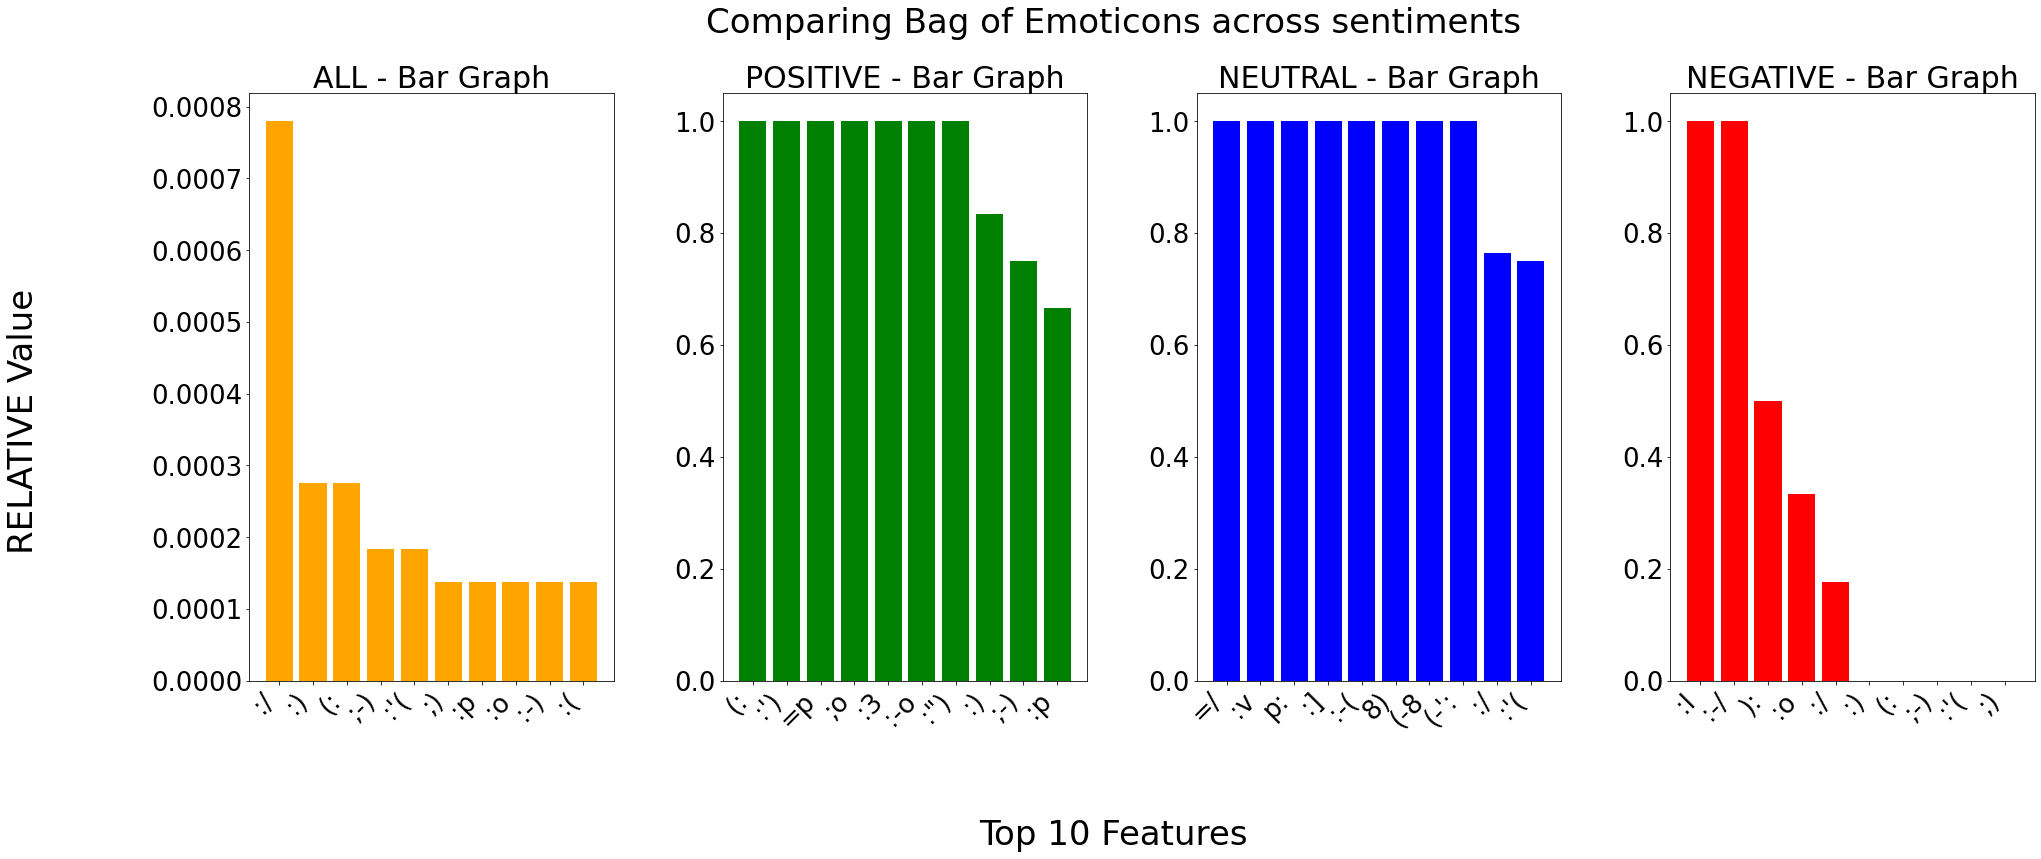

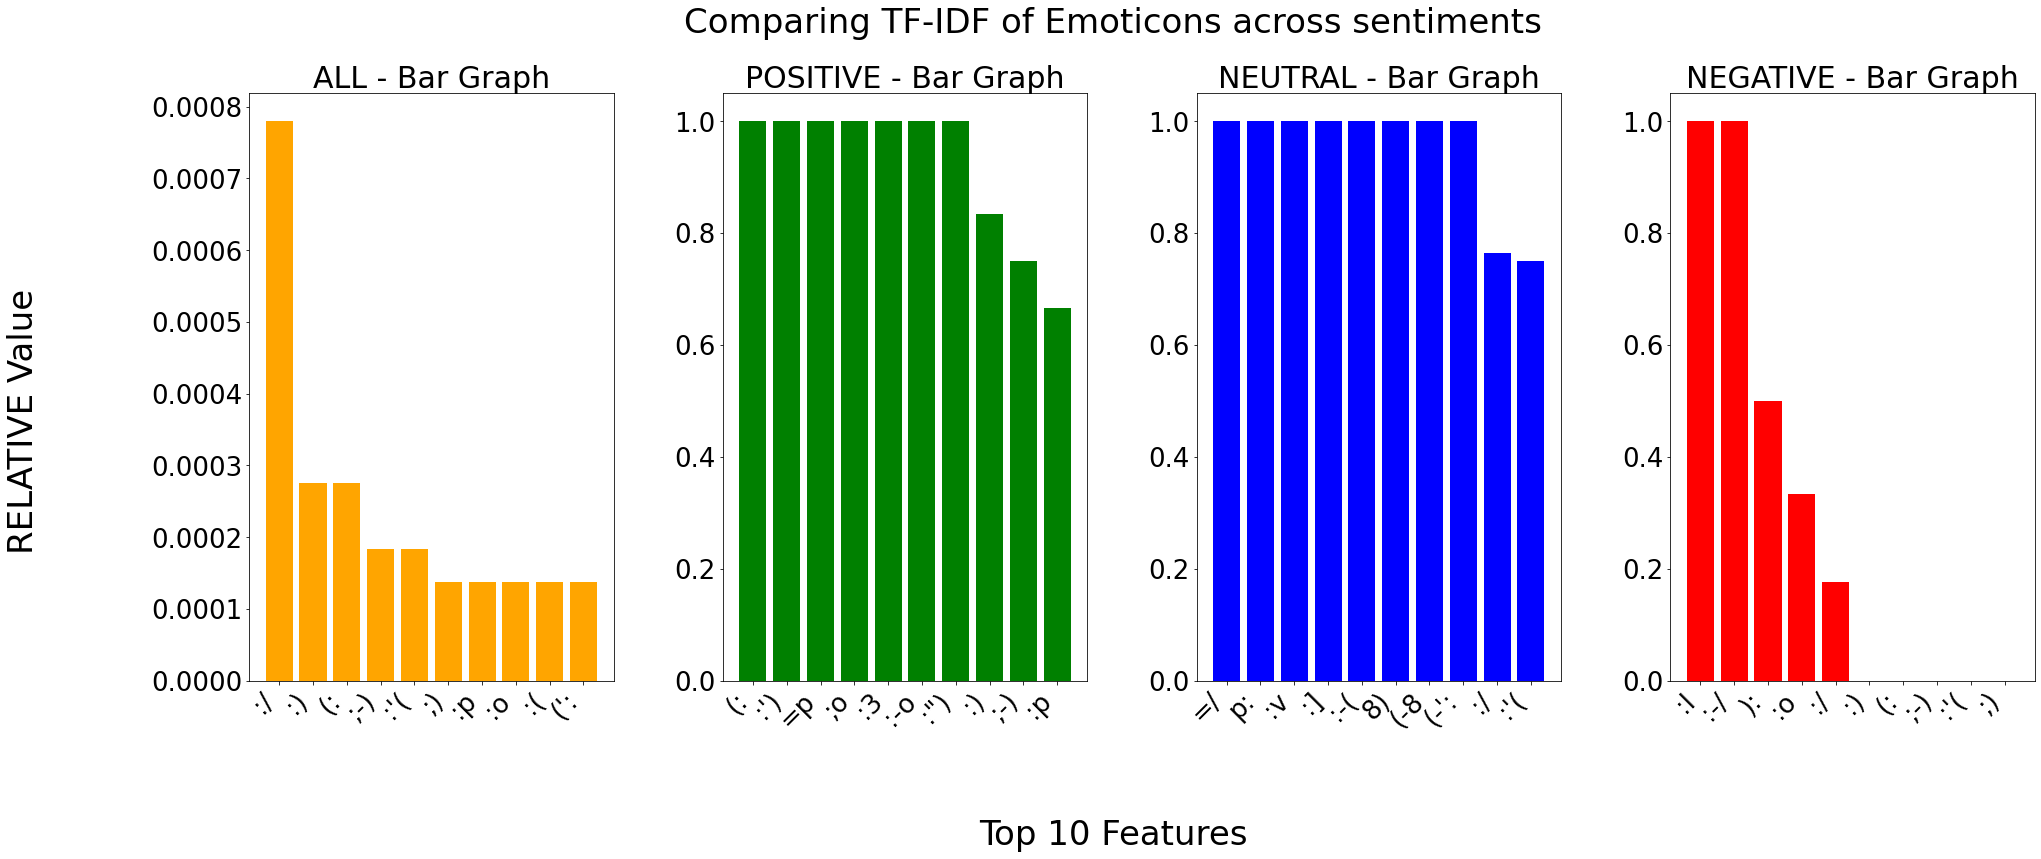

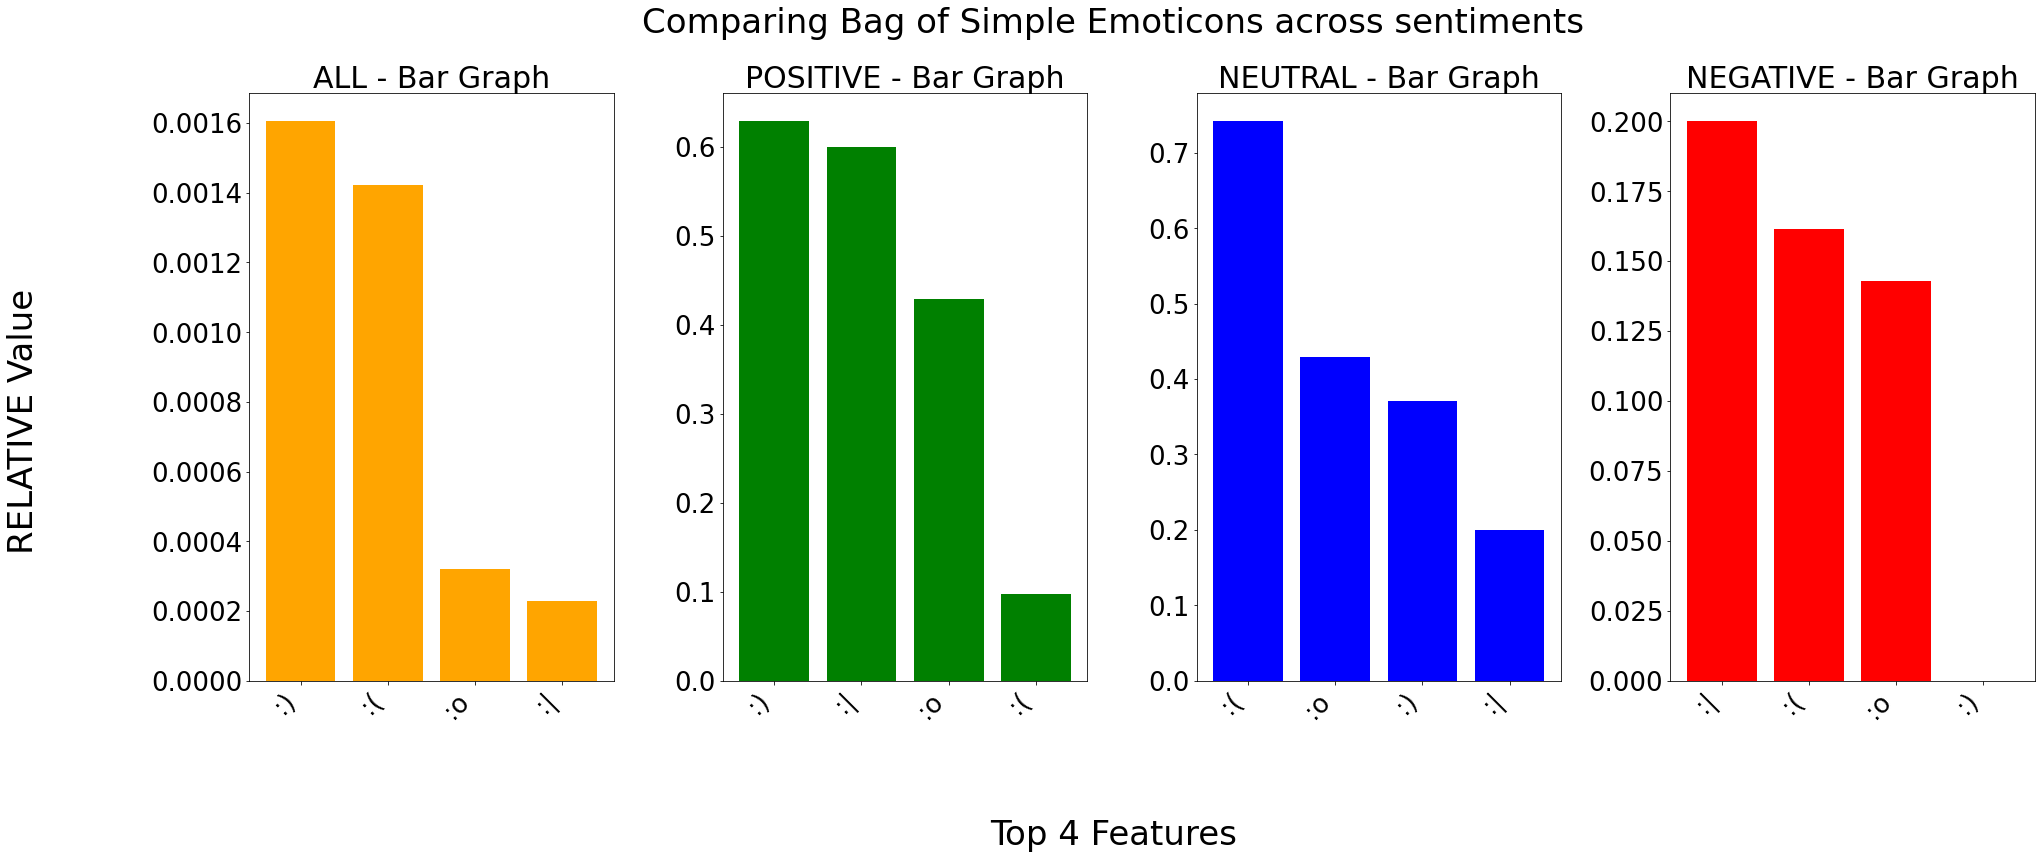

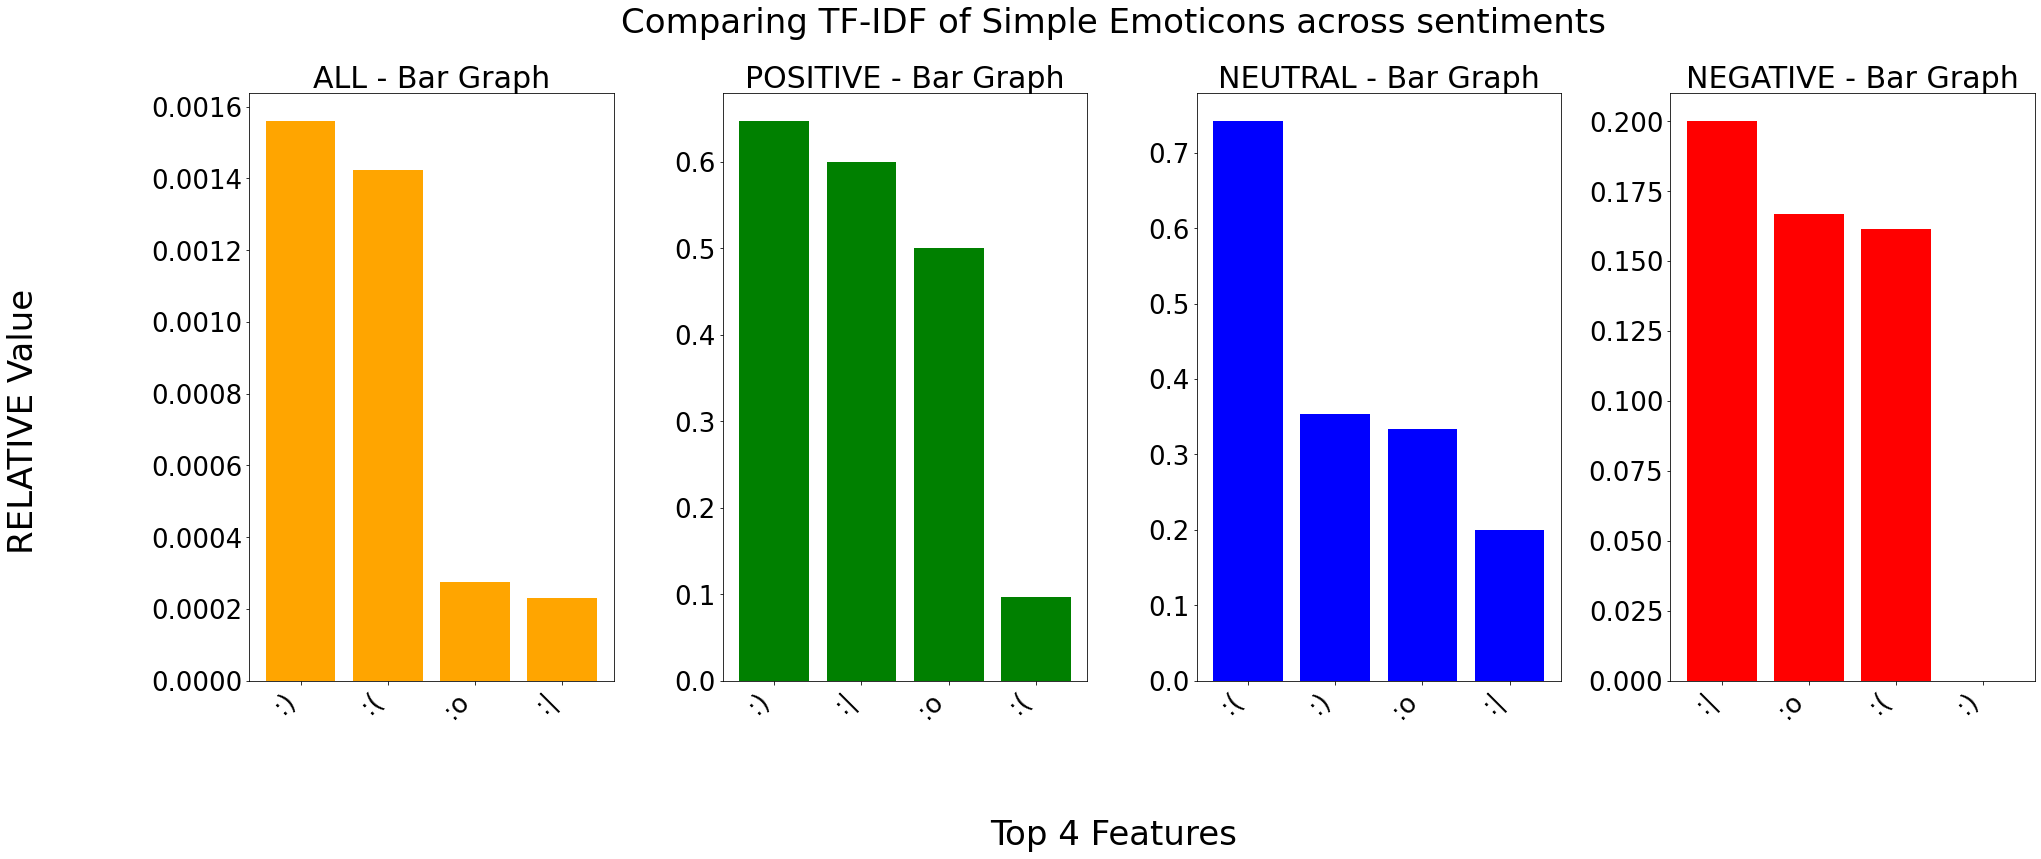

In [25]:
# tokenize into emotes
def tokenizer_emotes(tweet, remove_repeated=True, simplify=False): 
    if remove_repeated:
        tweet = re.sub(r'(.)\1+', r'\1', tweet)
    emotes = RE_EMOTES.findall(tweet)
    # prune numbers/decimals emotes
    emotes = [e for e in emotes if not (e.isalnum() or e.isdecimal() or e.isdigit())]
    if simplify:
        return [simplify_emoticon(e) for e in emotes]
    return emotes

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_COUNT = 'Bag of Emoticons'
cv_emo = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
X_train_features[FEATURE_EMOTICONS_COUNT] = cv_emo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_COUNT] = cv_emo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_COUNT], y, cv_emo.get_feature_names_out(), FEATURE_EMOTICONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_TFIDF = 'TF-IDF of Emoticons'
tfidf_emo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
X_train_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_TFIDF], y, tfidf_emo.get_feature_names_out(), FEATURE_EMOTICONS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_SIMPLE_COUNT = 'Bag of Simple Emoticons'
cv_simemo = CountVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT], y, cv_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_SIMPLE_TFIDF = 'TF-IDF of Simple Emoticons'
tfidf_simemo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF], y, tfidf_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_TFIDF)


### Phonetics

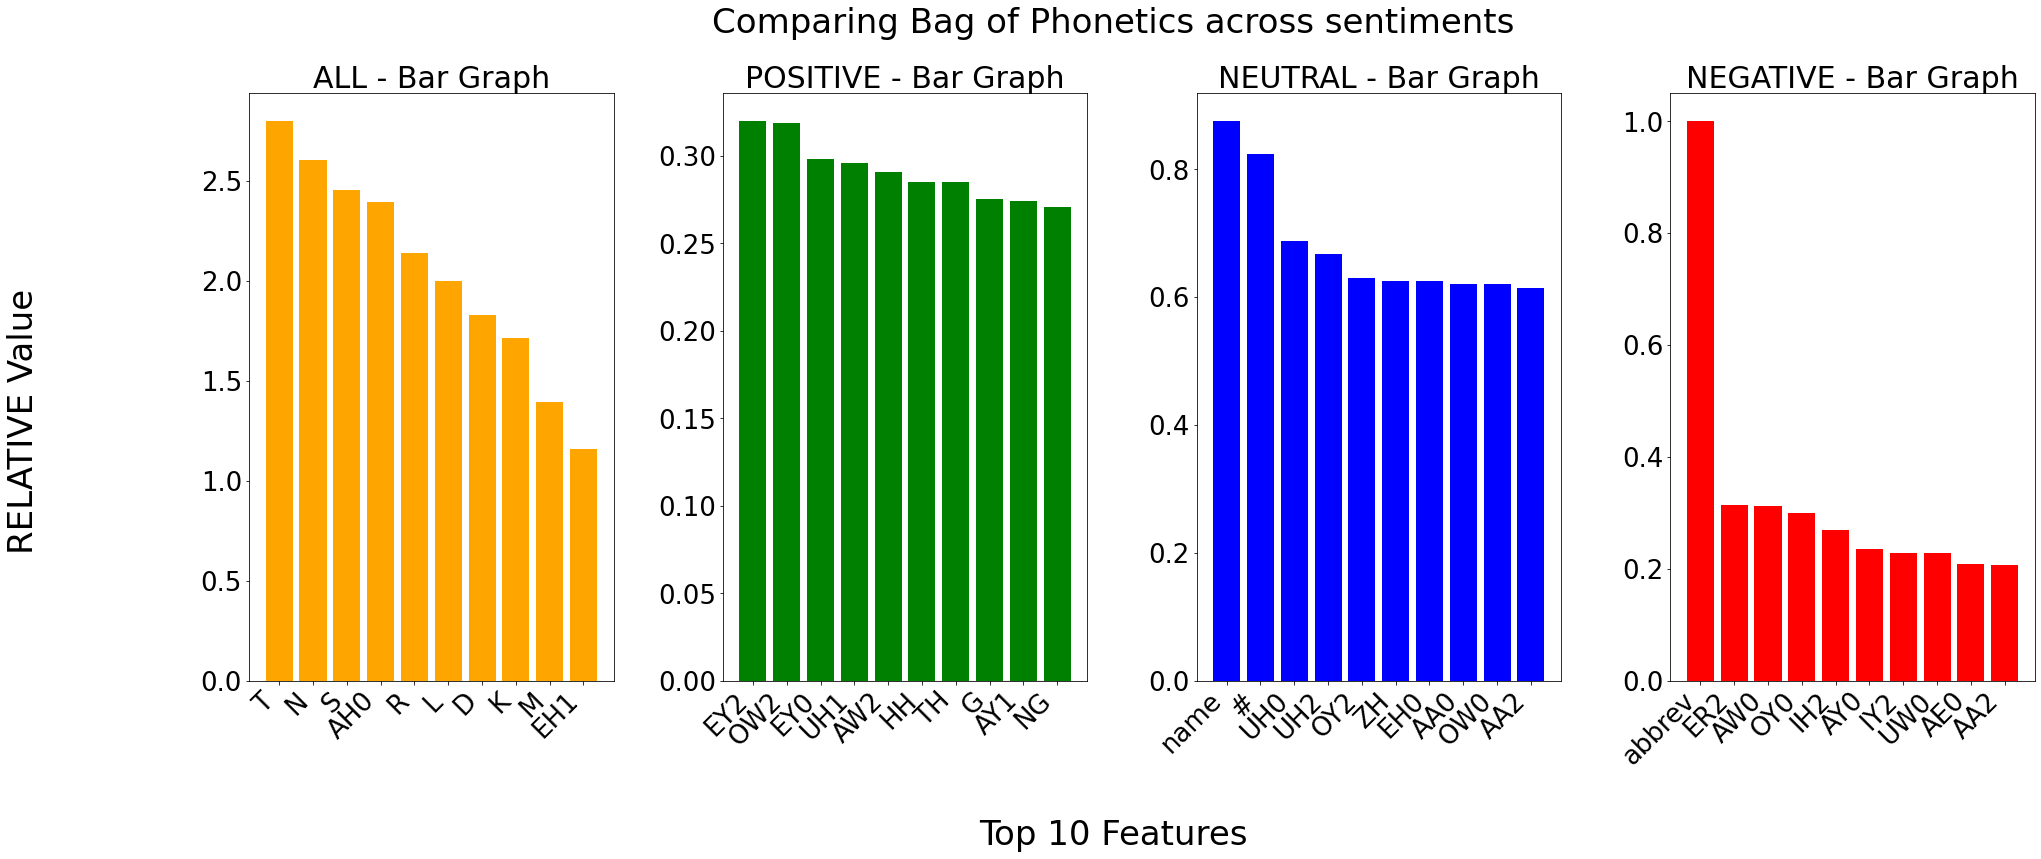

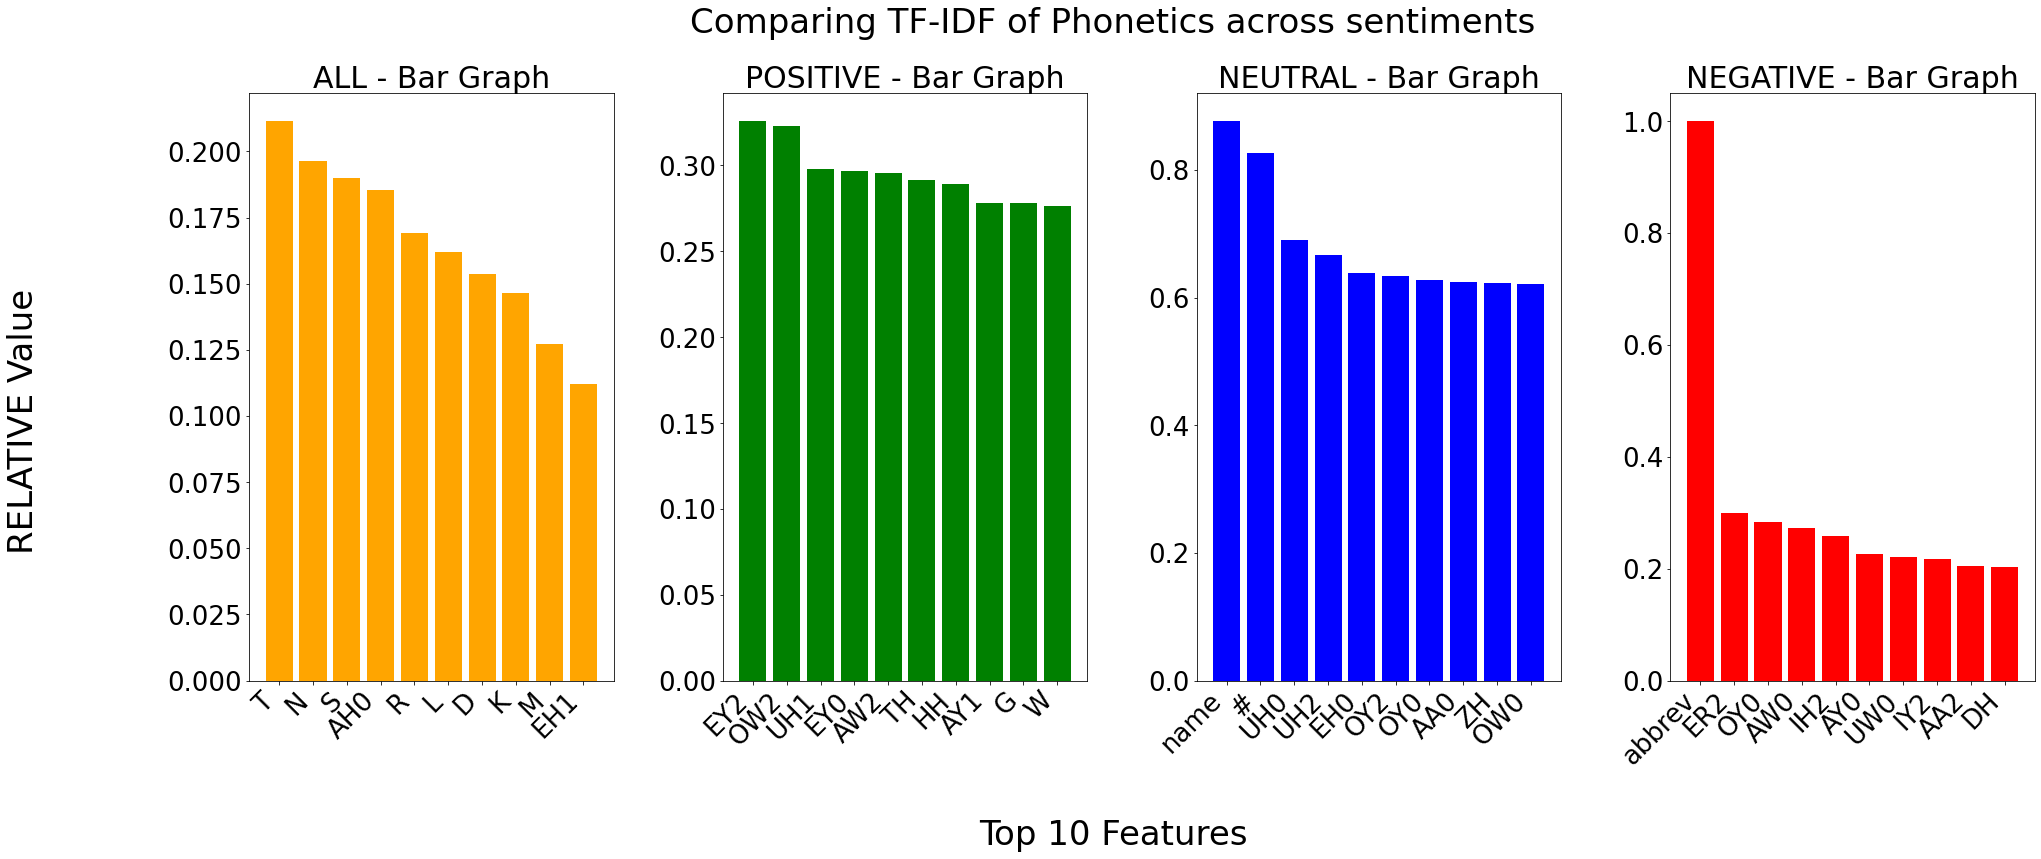

In [26]:
def tokenizer_phonetic(tweet): 
    wlist = tweet.split(' ')
    all_phones = []
    for w in wlist:
        # get the phones breakdown of the words
        phones = pronouncing.phones_for_word(w)
        # break the phones into a list and add to it
        if len(phones) > 0:
            all_phones += phones[0].split(' ')
    return all_phones

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PHONETICS_COUNT = 'Bag of Phonetics'
cv_ph = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
X_train_features[FEATURE_PHONETICS_COUNT] = cv_ph.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_PHONETICS_COUNT] = cv_ph.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_PHONETICS_COUNT], y, cv_ph.get_feature_names_out(), FEATURE_PHONETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PHONETICS_TFIDF = 'TF-IDF of Phonetics'
tfidf_ph = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
X_train_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_PHONETICS_TFIDF], y, tfidf_ph.get_feature_names_out(), FEATURE_PHONETICS_TFIDF)

### Poetic Phonetics

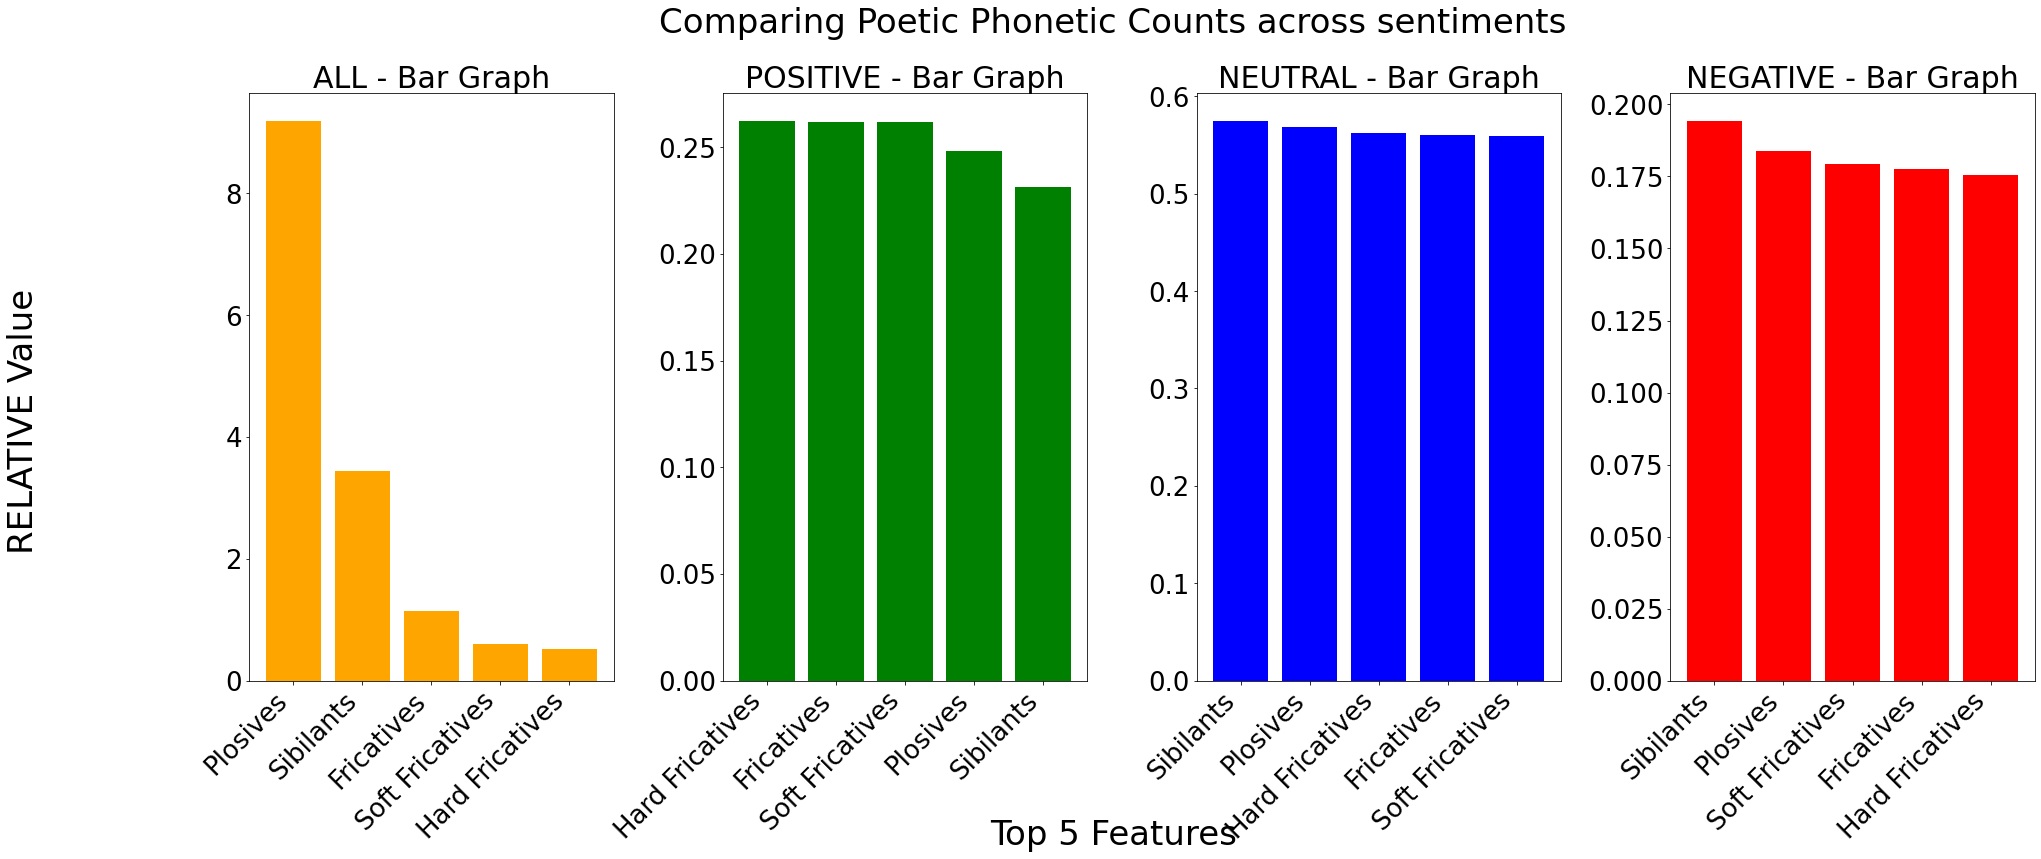

In [27]:
FEATURE_POETICS = 'Poetic Phonetic Counts'
plosive_set = ['B', 'P', 'D', 'T', 'G', 'K',
                'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
ch_plosive = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"
RE_PLOSIVES = re.compile(ch_plosive)

fricative_hard_set = ['DH', 'V']
ch_fricative_hard = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"
RE_FRICATIVES_HARD = re.compile(ch_fricative_hard)

fricative_soft_set = ['TH', 'F']
ch_fricative_soft = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"
RE_FRICATIVES_SOFT = re.compile(ch_fricative_soft)

fricative_set = fricative_hard_set + fricative_soft_set
ch_fricative = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_set) + r"(?=[ $])"
RE_FRICATIVES = re.compile(ch_fricative)

sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
ch_sibilant = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"
RE_SIBILANTS = re.compile(ch_sibilant)

def dictorizer_poetic_counts(tweets): 
    dict_list = []

    for t in tweets:
        wlist = t.split(' ')
        all_phones = ''
        for w in wlist:
            # get the phones breakdown of the words
            phones = pronouncing.phones_for_word(w)
            # break the phones into a list and add to it
            if len(phones) > 0:
                all_phones += phones[0]
        str_phones = ' '.join(all_phones)
        t_dict = {
            'Plosives': len(RE_PLOSIVES.findall(str_phones)),
            'Sibilants': len(RE_SIBILANTS.findall(str_phones)),
            'Fricatives': len(RE_FRICATIVES.findall(str_phones)),
            'Hard Fricatives': len(RE_FRICATIVES_HARD.findall(str_phones)),
            'Soft Fricatives': len(RE_FRICATIVES_SOFT.findall(str_phones)),
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_poe = DictVectorizer()
X_train_features[FEATURE_POETICS] = dv_poe.fit_transform(dictorizer_poetic_counts(train_df['text-clean']))
X_test_features[FEATURE_POETICS] = dv_poe.transform(dictorizer_poetic_counts(test_df['text-clean']))
compare_bars(X_train_features[FEATURE_POETICS], y, dv_poe.get_feature_names_out(), FEATURE_POETICS)

### General Metrics

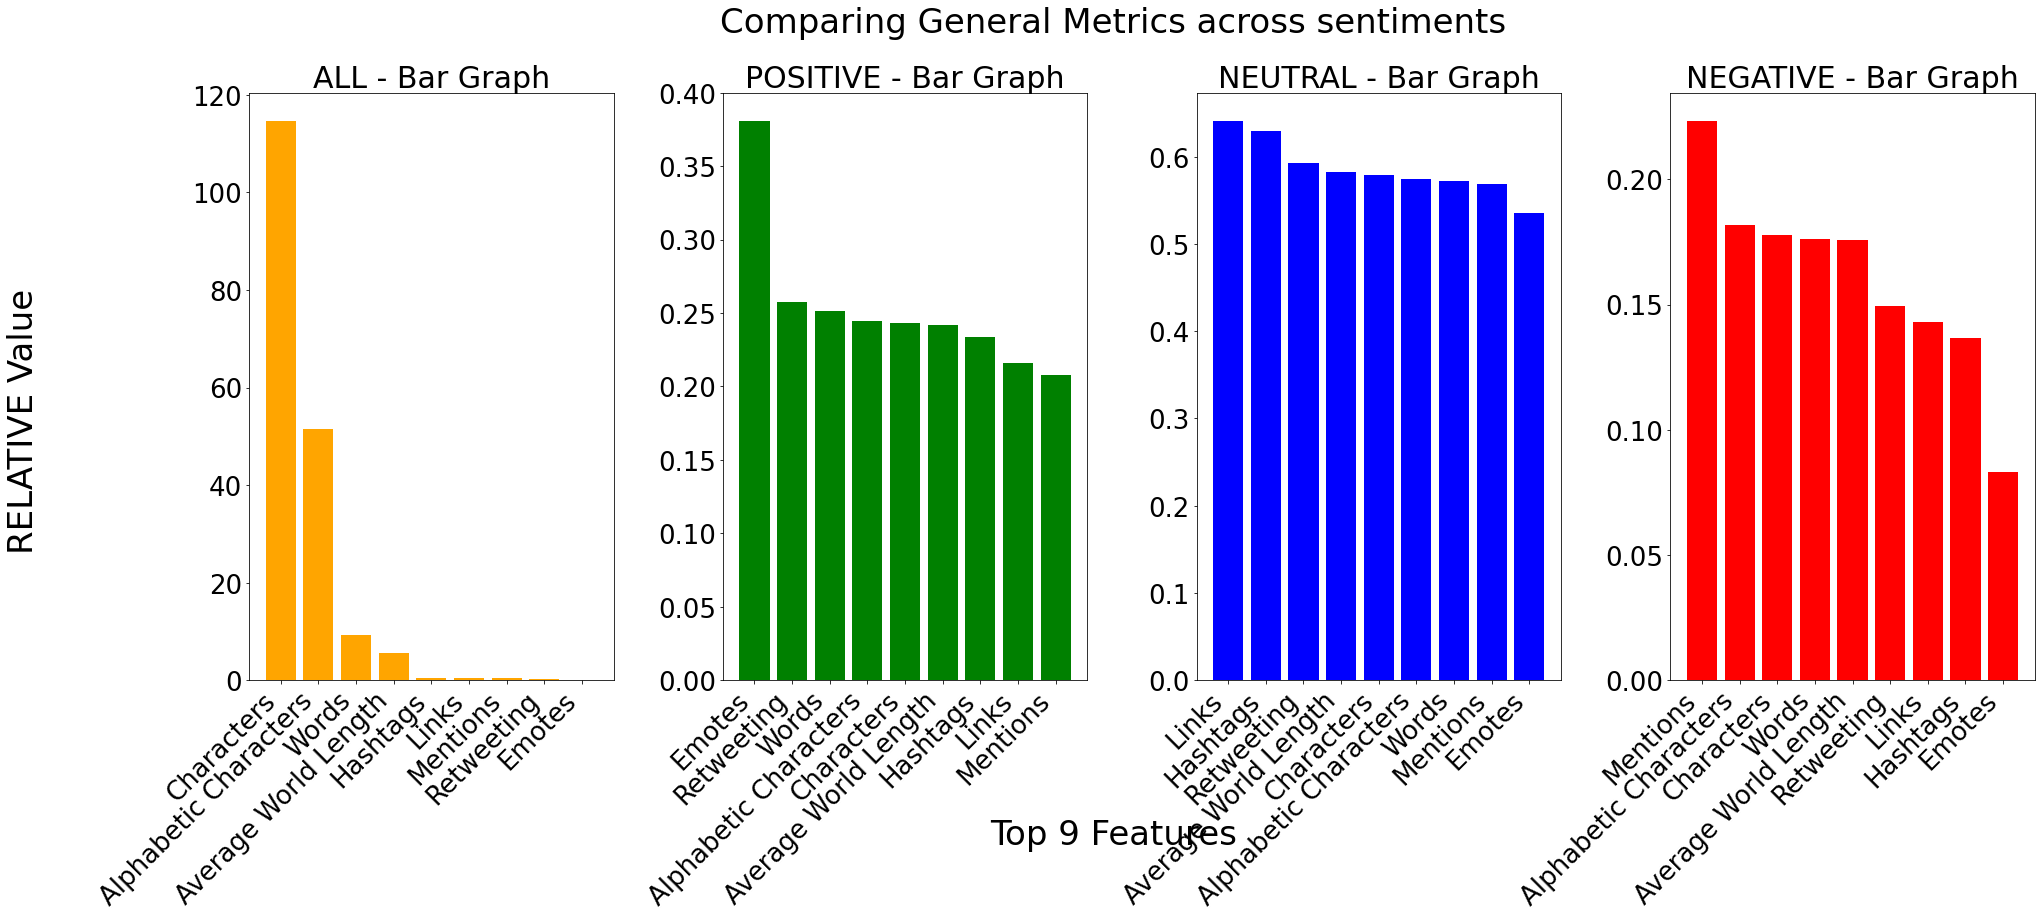

In [28]:
FEATURE_METRICS = 'General Metrics'
def dictorizer_metrics(tweets: list[str], tweets_cleaned: list[str]): 
    dict_list = []
    for t, t_clean in zip(tweets, tweets_cleaned):
        wlist = t_clean.split(' ')
        total_wlen = 0
        for w in wlist:
            total_wlen += len(w)

        t_dict = {
            'Links': len(RE_LINKS.findall(t)),
            'Hashtags': len(RE_HASHTAGS.findall(t)),
            'Mentions': len(RE_MENTIONS.findall(t)),
            'Words': len(wlist),
            'Average World Length': total_wlen / len(wlist),
            'Emotes': len(RE_EMOTES.findall(t)),
            'Retweeting': ('"' in t),
            'Characters': len(t),
            'Alphabetic Characters': len(re.sub(r' +', '', t_clean))
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_metrics = DictVectorizer()
X_train_features[FEATURE_METRICS] = dv_metrics.fit_transform(dictorizer_metrics(train_df['text'], train_df['text-clean']))
X_test_features[FEATURE_METRICS] = dv_metrics.transform(dictorizer_metrics(test_df['text'], test_df['text-clean']))
compare_bars(X_train_features[FEATURE_METRICS], y, dv_metrics.get_feature_names_out(), FEATURE_METRICS)

## 5. Model Selection

Selecting, training, and evaluating possible models.

### Helper Functions

In [29]:
# Combine the chosen tokens into one matrix
# Generate the final train and test sets
def combine_X_matrices(train_dict: dict, test_dict: dict, feature_types: list[str]):
    X_Train = hstack([train_dict[ft] for ft in feature_types])
    X_Test = hstack([test_dict[ft] for ft in feature_types])
    
    return (X_Train, X_Test)

### Generating Features

In [30]:
# Choose the features for the train and test sets
CHOSEN_FEATURES = [
    FEATURE_HASHTAGS_COUNT,
    FEATURE_MENTIONS_COUNT,
    FEATURE_LINKS_COUNT,
    FEATURE_POS_TAGS_COUNT, 
    FEATURE_WORDS_COUNT, 
    FEATURE_WORD_2GRAMS_COUNT,
    FEATURE_PUNCTUATION_TFIDF,
    FEATURE_EMOTICONS_SIMPLE_TFIDF,
    FEATURE_METRICS]
X_train, X_test = combine_X_matrices(X_train_features, X_test_features, CHOSEN_FEATURES)

print(f'\tModified Training Set Shape: {X_train.shape}')
print(f'\tModified Testing Set Shape: {X_test.shape}')

	Modified Training Set Shape: (21802, 24508)
	Modified Testing Set Shape: (6099, 24508)


### Evaluation

#### Distribution generation

In [120]:
# function to display the distribution of a train and test split
def show_save_sentiment_distribution(d_y_train, d_y_test, y, split_type):
    labels  = []
    weights = []
    colours = []
    for s in sorted(set(y), reverse=True):
        labels.append(f'Training {s}')
        weights.append(len(d_y_train[d_y_train == s]))
        colours.append(SENTIMENT_COLOURS[s])

        labels.append(f'Testing {s}')
        weights.append(len(d_y_test[d_y_test == s]))
        colours.append('dark' + SENTIMENT_COLOURS[s])

    plt.figure(figsize= (16, 9))
    plt.bar(labels, weights, color=colours)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution of the Sentiments in a {split_type.upper()} Split')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.savefig(f'../report/img/train-test-sentiments-{split_type}', bbox_inches='tight')


SPLIT_UNIFORM = 'Uniform'
SPLIT_RANDOM = 'Random'

### generating splits (and comparing the distributions of the true sentiments)
# generate a split similar to the overall sentiment distribution
def generate_datadist_sentiments(X:csr_matrix, y, train_uniform_len, test_uniform_len):
    return train_test_split(X, y, train_size=train_uniform_len, test_size=test_uniform_len, random_state=101)

# generate a uniform split
def generate_uniform_sentiments(X:csr_matrix, y, test_size:float = 0.2):

    # number of elements per sentiment
    n = int(len(y) / 3)

    # ensure that n is not greater than any sentiments actual count
    for s in set(y):
        n = min(len(y[y == s]), n)

    # create the train and test sizes
    train_n = int((1 - test_size) * n)
    test_n = int((test_size) * n)

    # extract the different sentiment values
    _X_train = None
    _X_test = None
    _y_train = []
    _y_test = []

    for s in set(y):
        if _X_train == None:
            _X_train    = X[y == s][:train_n]
            _X_test     = X[y == s][-test_n:]
            _y_train    = y[y == s][:train_n]
            _y_test     = y[y == s][-test_n:]
        else:
            _X_train    = vstack([_X_train, X[y == s][:train_n]])
            _X_test     = vstack([_X_test, X[y == s][-test_n:]])
            _y_train    = pd.concat([_y_train, y[y == s][:train_n]])
            _y_test     = pd.concat([_y_test, y[y == s][-test_n:]])

    return _X_train, _X_test, _y_train, _y_test

#### Testing different train/test splits

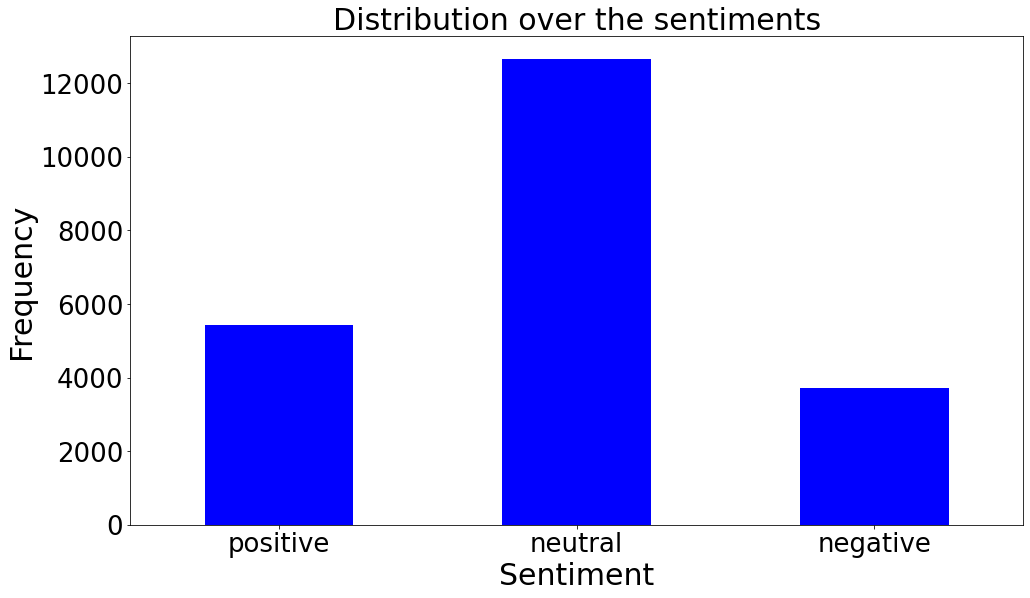

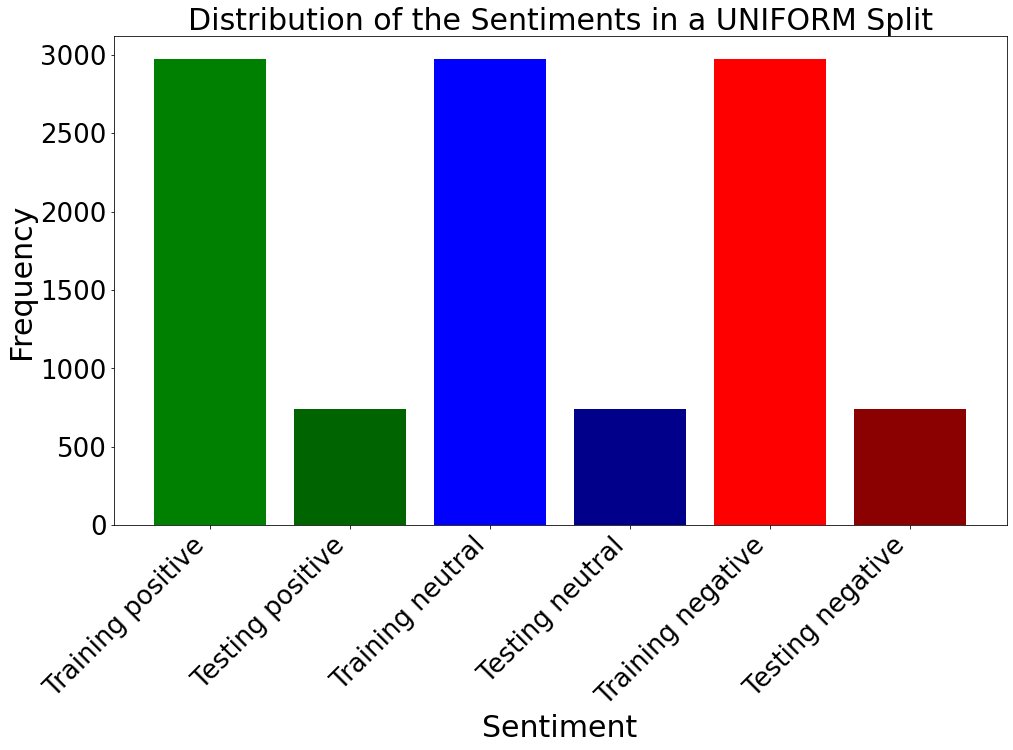

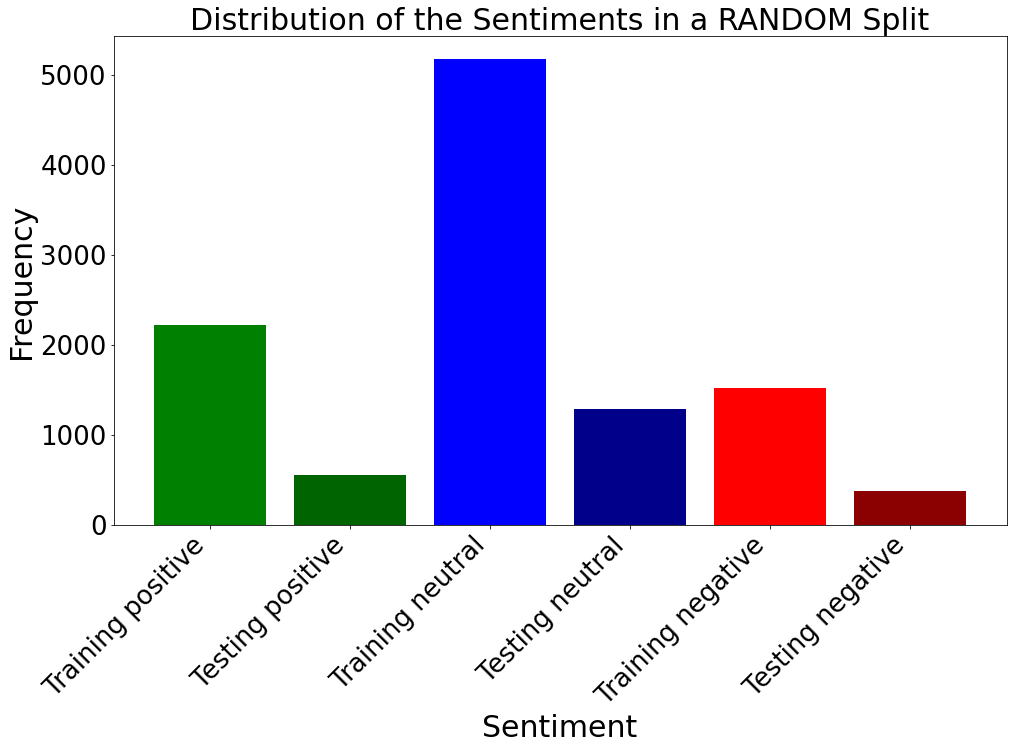

In [121]:
# as a reminder: Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(X_train, y)
show_save_sentiment_distribution(uni_y_train, uni_y_test, y, 'Uniform')

rand_X_train, rand_X_test, rand_y_train, rand_y_test = generate_datadist_sentiments(X_train, y, 
    train_uniform_len=len(uni_y_train), test_uniform_len=len(uni_y_test))
show_save_sentiment_distribution(rand_y_train, rand_y_test, y, 'Random')

#### Evaluation Functions

In [171]:
# evaluate the cross validation score for the model
def evaluate_score(model, _X, _y, cv = 5):
    scores = cross_val_score(model,  _X, _y, cv = cv)
    return {
        'scores': scores,
        'average': np.ma.average(scores),
        'std': np.ma.std(scores)
    }

# generate the evaluation metrics and confusion matrix on a model on given data
def evaluate_metrics(model, _X_train, _X_test, _y_train, _y_test, split_type:str = '', model_name:str = '', display:bool = False):
    # fit the data and predict
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)

    # append a dictionary of the evaluation summaries
    output = {
        'data': (rand_X_train, rand_X_test, rand_y_train, rand_y_test, _y_pred),
        'evaluation-string': classification_report(_y_test, _y_pred, zero_division=0),
        'evaluation': classification_report(_y_test, _y_pred, output_dict=True, zero_division=0),
        'confusion-matrix': confusion_matrix(_y_test, _y_pred)
    }

    # display the stuff if needed
    if display:
        print(output['evaluation-string'])
        plt.figure(figsize=(32, 18))
        ConfusionMatrixDisplay.from_predictions(_y_test, _y_pred, xticks_rotation=45,
            labels = sorted(set(_y_test), reverse=True))
        plt.title(f'{model_name}\nConfusion Matrix on {split_type.upper()} Data')
        plt.savefig(f'../report/img/cf/{model_name}-{split_type}-confusion-matrix', bbox_inches='tight')

    return output

SPLIT_ALL = 'All'
# evaluate a model on the different data splits, then on overall data
def evaluate(model, _X, _y, model_name:str = '', display:bool=False):
    output = {}

    # get the uniform split
    if display: print(f'=== Over {SPLIT_UNIFORM} Data ===')
    uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(_X, _y)
    output[SPLIT_UNIFORM] = evaluate_metrics(model, uni_X_train, uni_X_test, uni_y_train, uni_y_test, 
        split_type=SPLIT_UNIFORM, model_name=model_name, display=display)

    # get the random split
    if display: print(f'=== Over {SPLIT_RANDOM} Data ===')
    rand_X_train, rand_X_test, rand_y_train, rand_y_test = generate_datadist_sentiments(_X, _y, 
        train_uniform_len=len(uni_y_train), test_uniform_len=len(uni_y_test))
    output[SPLIT_RANDOM] = evaluate_metrics(model, rand_X_train, rand_X_test, rand_y_train, rand_y_test, 
        split_type=SPLIT_RANDOM, model_name=model_name, display=display)
    
    # now test evaluate over the whole set
    if display: print(f'=== Over {SPLIT_ALL} Data ===')
    output[SPLIT_ALL] = evaluate_metrics(model, _X, _X, _y, _y,
        split_type=SPLIT_ALL, model_name=model_name, display=display)
    
    return output

#### Start the model dictionairy

In [165]:
TYPE_CLASSIFIER = 'classifier'
TYPE_SCORES = 'cv-scores'
TYPE_EVALUATION = 'evaluation'
# will store the cv scores of all the models below, which can then be used to find the best 3 models.
models = {}

### Baseline Model (0-R)

Most Frequent Class (0-R)
{'average': 0.5806348072679232,
 'scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58050459]),
 'std': 8.823785859666561e-05}
=== Over Uniform Data ===
              precision    recall  f1-score   support

    negative       0.33      1.00      0.50       743
     neutral       0.00      0.00      0.00       743
    positive       0.00      0.00      0.00       743

    accuracy                           0.33      2229
   macro avg       0.11      0.33      0.17      2229
weighted avg       0.11      0.33      0.17      2229

=== Over Random Data ===
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       378
     neutral       0.58      1.00      0.73      1290
    positive       0.00      0.00      0.00       561

    accuracy                           0.58      2229
   macro avg       0.19      0.33      0.24      2229
weighted avg       0.33      0.58      0.42      2229

=== Over All Data 

<Figure size 2304x1296 with 0 Axes>

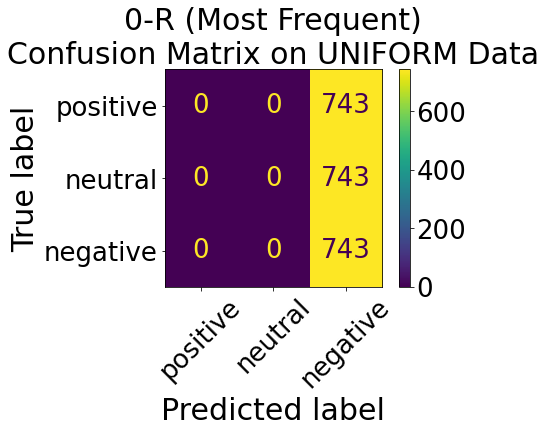

<Figure size 2304x1296 with 0 Axes>

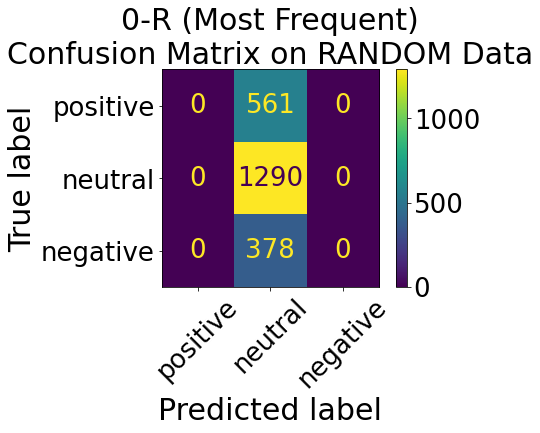

<Figure size 2304x1296 with 0 Axes>

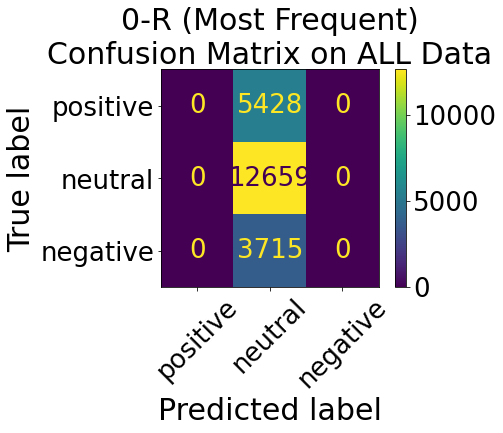

In [172]:
model_name = 'Most Frequent Class (0-R)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = DummyClassifier(strategy="most_frequent")

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name, display=True)

models[model_name] = model

### Multinomial Naive Bayes

In [173]:
model_name = 'Multinomial Naive Bayes'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = MultinomialNB()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Multinomial Naive Bayes (Without Smoothing)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = MultinomialNB(alpha=0)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Multinomial Naive Bayes (Without Priors)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = MultinomialNB(fit_prior=False)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

Multinomial Naive Bayes
{'average': 0.6427841964535531,
 'scores': array([0.65466636, 0.64985095, 0.65756881, 0.61811927, 0.6337156 ]),
 'std': 0.014834472554833791}
Multinomial Naive Bayes (Without Smoothing)
{'average': 0.5795337425765069,
 'scores': array([0.5861041 , 0.57830773, 0.57775229, 0.56949541, 0.58600917]),
 'std': 0.006173258619342564}
Multinomial Naive Bayes (Without Priors)
{'average': 0.6311800803199334,
 'scores': array([0.64044944, 0.63379959, 0.64357798, 0.61376147, 0.62431193]),
 'std': 0.010927674628822194}


### Bernoulli Naive Bayes

In [177]:
model_name = 'Bernoulli Naive Bayes'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BernoulliNB()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Bernoulli Naive Bayes (Without Smoothing)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BernoulliNB(alpha=0)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Bernoulli Naive Bayes (Without Priors)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BernoulliNB(fit_prior=False)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

Bernoulli Naive Bayes
{'average': 0.6439767623367252,
 'scores': array([0.65604219, 0.65053887, 0.6587156 , 0.62155963, 0.63302752]),
 'std': 0.014340729234183622}
Bernoulli Naive Bayes (Without Smoothing)
{'average': 0.5799923529869633,
 'scores': array([0.58633341, 0.58037147, 0.5793578 , 0.5662844 , 0.58761468]),
 'std': 0.007573151534101468}
Bernoulli Naive Bayes (Without Priors)
{'average': 0.6360876008995496,
 'scores': array([0.64870443, 0.64159596, 0.6483945 , 0.61238532, 0.6293578 ]),
 'std': 0.013770071146524844}


### Logistic Regression

In [179]:
# the convergence warning takes up too much space so it's suppressed, but noted
warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)

model_name = 'Logistic Regression'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LogisticRegression()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Logistic Regression (500 Max Iterations)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LogisticRegression(max_iter=500)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Logistic Regression (Without Intercept)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LogisticRegression(fit_intercept=False)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Logistic Regression (`Sag` Solver)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LogisticRegression(solver='sag')

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Logistic Regression (`Saga` Solver)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LogisticRegression(solver='saga')

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

Logistic Regression
{'average': 0.6146681806420126,
 'scores': array([0.62783765, 0.60582435, 0.62591743, 0.60252294, 0.61123853]),
 'std': 0.010367867424441644}
Logistic Regression (500 Max Iterations)
{'average': 0.655626855215852,
 'scores': array([0.67140564, 0.66315065, 0.66261468, 0.6309633 , 0.65      ]),
 'std': 0.014102195704287055}
Logistic Regression (Without Intercept)
{'average': 0.6190709352496797,
 'scores': array([0.62646182, 0.62714974, 0.61766055, 0.60481651, 0.61926606]),
 'std': 0.008063597247446125}
Logistic Regression (`Sag` Solver)
{'average': 0.5909558555924173,
 'scores': array([0.58037147, 0.58197661, 0.58165138, 0.5809633 , 0.62981651]),
 'std': 0.01943826722570433}
Logistic Regression (`Saga` Solver)
{'average': 0.5878825136899415,
 'scores': array([0.58060078, 0.58060078, 0.58050459, 0.58073394, 0.61697248]),
 'std': 0.014545164871141972}


### Decision Tree

In [178]:
model_name = 'Decision Tree'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = DecisionTreeClassifier()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Decision Tree (Max Depth 1)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = DecisionTreeClassifier(max_depth=1)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Decision Tree (Max Depth 100)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = DecisionTreeClassifier(max_depth=100)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Decision Tree (Max Depth 1000)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = DecisionTreeClassifier(max_depth=1000)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

Decision Tree
{'average': 0.5541691473001942,
 'scores': array([0.56019262, 0.55239624, 0.55114679, 0.54816514, 0.55894495]),
 'std': 0.004635007983164865}
Decision Tree (Max Depth 1)
{'average': 0.5942113899471757,
 'scores': array([0.60077964, 0.59091951, 0.60412844, 0.58509174, 0.59013761]),
 'std': 0.0071005608064749265}
Decision Tree (Max Depth 100)
{'average': 0.5623795884707868,
 'scores': array([0.56454942, 0.56042192, 0.56307339, 0.55802752, 0.56582569]),
 'std': 0.002822695580560348}
Decision Tree (Max Depth 1000)
{'average': 0.5563245005248775,
 'scores': array([0.55973401, 0.56615455, 0.55366972, 0.54633028, 0.55573394]),
 'std': 0.006565603750448589}


### K Nearest Neighbours

In [162]:
# default KNN
knn = KNeighborsClassifier()
knn_scores = evaluate_score(knn, X_train, y)
pprint(knn_scores)

# KNN with different n neighbours
knn_n_1 = KNeighborsClassifier(n_neighbors=1)
knn_n_1_scores = evaluate_score(knn_n_1, X_train, y)
pprint(knn_n_1_scores)
knn_n_100 = KNeighborsClassifier(n_neighbors=100)
knn_n_100_scores = evaluate_score(knn_n_100, X_train, y)
pprint(knn_n_100_scores)
knn_n_1000 = KNeighborsClassifier(n_neighbors=1000)
knn_n_1000_scores = evaluate_score(knn_n_1000, X_train, y)
pprint(knn_n_1000_scores)

{'average': 0.5148152830867426,
 'scores': array([0.51410227, 0.51272644, 0.50917431, 0.525     , 0.51307339]),
 'std': 0.0053563951994497075}
{'average': 0.4644987577548285,
 'scores': array([0.46526026, 0.46182068, 0.46743119, 0.46192661, 0.46605505]),
 'std': 0.002253403861638043}
{'average': 0.5806348072679232,
 'scores': array([0.58014217, 0.58105939, 0.5809633 , 0.58050459, 0.58050459]),
 'std': 0.0003360912420057193}
{'average': 0.5806348072679232,
 'scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58050459]),
 'std': 8.823785859666561e-05}


### Support Vector Machine

In [ ]:
model_name = 'Support Vector Classifier'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = SVC()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Support Vector Classifier (Linear)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = LinearSVC()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Support Vector Classifier (Cubic)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = SVC(kernel='poly', degree=3)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

model_name = 'Support Vector Classifier (10-nomial)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = SVC(kernel='poly', degree=10)

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

{'average': 0.5806348072679232,
 'scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58050459]),
 'std': 8.823785859666561e-05}
{'average': 0.6417292873236295,
 'scores': array([0.63792708, 0.66360926, 0.64587156, 0.60733945, 0.65389908]),
 'std': 0.019189129362983205}
{'average': 0.5805889357082901,
 'scores': array([0.58060078, 0.58060078, 0.58073394, 0.58073394, 0.58027523]),
 'std': 0.000167778183578077}
{'average': 0.5915511550460819,
 'scores': array([0.59252465, 0.59229535, 0.59266055, 0.58990826, 0.59036697]),
 'std': 0.0011690742312497567}


### Bagging Classifiers

In [183]:
model_name = 'Bagging Classifier'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BaggingClassifier()

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Bagging Classifier (Multinomial Naive Bayes)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BaggingClassifier(base_estimator=MultinomialNB())

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Bagging Classifier (Bernoulli Naive Bayes)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BaggingClassifier(base_estimator=BernoulliNB())

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Bagging Classifier (Logistic Regression)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BaggingClassifier(base_estimator=LogisticRegression())

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model


model_name = 'Bagging Classifier (Linear Support Vector Classifier)'
print(model_name)
model = {}
# create the model
model[TYPE_CLASSIFIER] = BaggingClassifier(base_estimator=LinearSVC())

# Evaluate the model
model[TYPE_SCORES] = evaluate_score(model[TYPE_CLASSIFIER], X_train, y)
pprint(model[TYPE_SCORES])
model[TYPE_EVALUATION] = evaluate(model[TYPE_CLASSIFIER], X_train, y, model_name)

models[model_name] = model

Bagging Classifier (Linear Support Vector Classifier)
{'average': 0.6496187327626649,
 'scores': array([0.65374914, 0.65787663, 0.65848624, 0.63348624, 0.64449541]),
 'std': 0.00949096022551806}
['negative' 'neutral' 'neutral' 'neutral' 'neutral']


### Choose the top 3 models
Done by sorting on `score avg - score std`